In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.optim import Adam
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from tqdm import trange
from copy import deepcopy

/home/jaiswalsuraj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


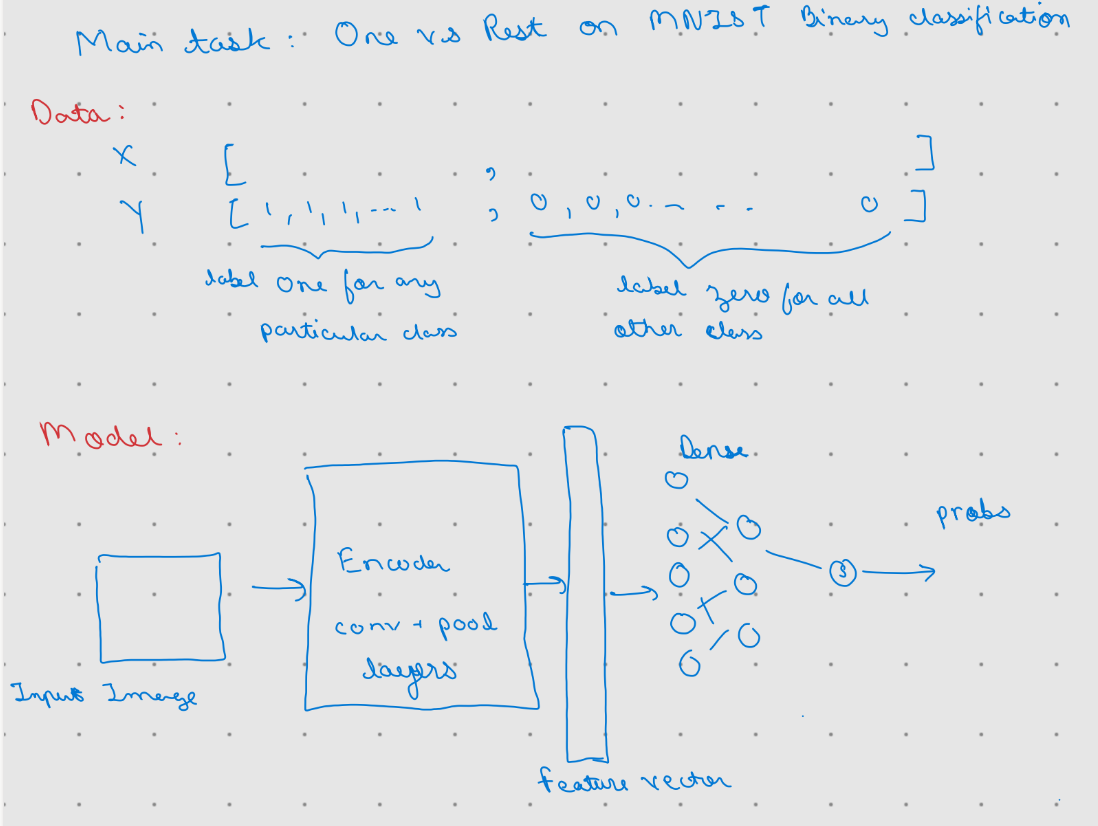
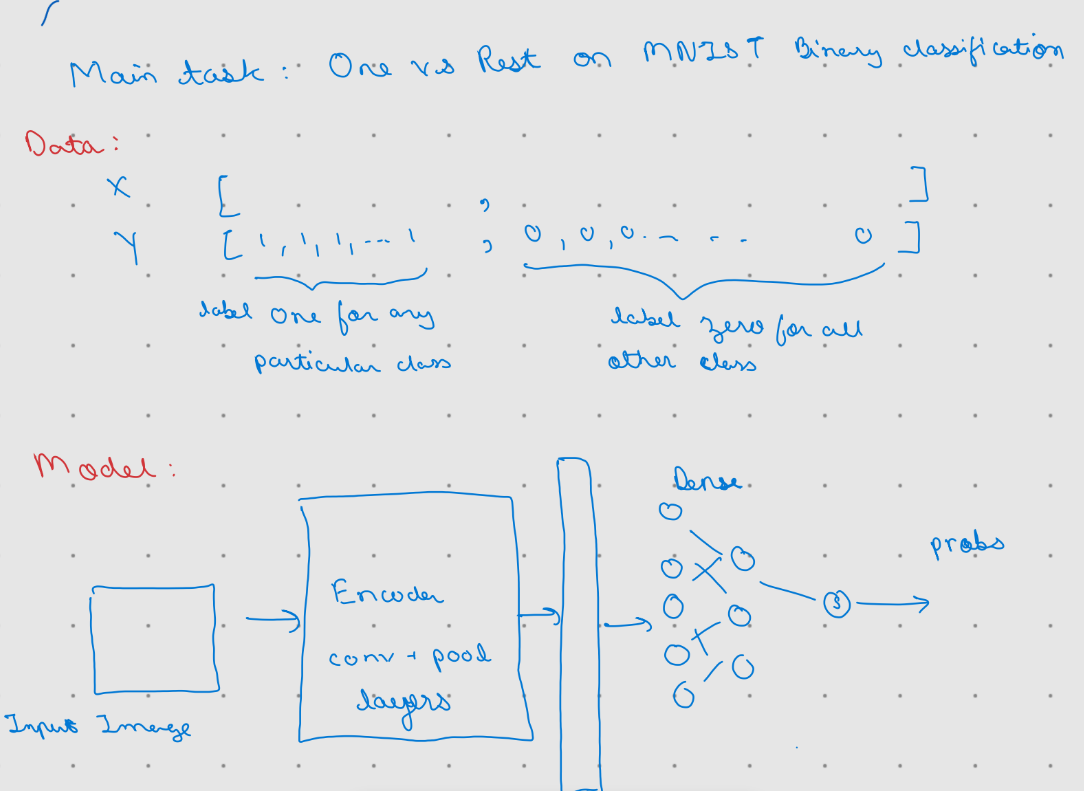

In [2]:
# List all available GPU devices
device_count = torch.cuda.device_count()
print(device_count) 
for i in range(device_count):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


4
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB
GPU 2: NVIDIA A100-SXM4-80GB
GPU 3: NVIDIA A100-SXM4-80GB


In [3]:
# Assign a specific GPU 
device = torch.device("cuda:0")
print("Selected Device:", torch.cuda.get_device_name(device))
print(device) 

Selected Device: NVIDIA A100-SXM4-80GB
cuda:0


In [4]:
train_dataset = MNIST(root='./data', train=True, download=True)
test_dataset = MNIST(root='./data', train=False, download=True)
train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
target_digit = 0
train_data_target = train_dataset.data[train_dataset.targets == target_digit]
train_data_rest = train_dataset.data[train_dataset.targets != target_digit]
train_data_target.shape, train_data_rest.shape 

(torch.Size([5923, 28, 28]), torch.Size([54077, 28, 28]))

In [6]:
test_data_target = test_dataset.data[test_dataset.targets == target_digit]
test_data_rest = test_dataset.data[test_dataset.targets != target_digit]
test_data_target.shape, test_data_rest.shape 

(torch.Size([980, 28, 28]), torch.Size([9020, 28, 28]))

Concating 

In [7]:
data_train = torch.cat((train_data_target, train_data_rest), dim=0)
label_train = torch.cat((torch.ones(len(train_data_target)), torch.zeros(len(train_data_rest))), dim=0)
data_test = torch.cat((test_data_target, test_data_rest), dim=0)
label_test = torch.cat((torch.ones(len(test_data_target)), torch.zeros(len(test_data_rest))), dim=0)   
data_train.shape, label_train.shape, data_test.shape, label_test.shape 

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [29]:
train_size = 1000
random_indices = torch.randperm(len(data_train))[:train_size]
x_train = data_train[random_indices]
y_train = label_train[random_indices]
x_train.shape, y_train.shape 

(torch.Size([1000, 28, 28]), torch.Size([1000]))

# CNN

Model defination

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 4, 3, padding=1)
        self.fc1 = nn.Linear(4 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

    def encoder(self,x):
        # gives features 
        x = x.view(-1, 1, 28, 28)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 4 * 3 * 3)
        return x 

    def forward(self, x, features=False):
        x = self.encoder(x) 
        # applying dense layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        return x 

model = CNN().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [10]:
# trying model for one image
output_temp = model(x_train[0].to(device).float())
print(output_temp, output_temp.shape)
label_temp = y_train[0].to(device).float().view(-1, 1)
print(label_temp, label_temp.shape)
loss_temp = criterion(output_temp, label_temp)
print(loss_temp) 

tensor([[0.9025]], device='cuda:0', grad_fn=<SigmoidBackward0>) torch.Size([1, 1])
tensor([[0.]], device='cuda:0') torch.Size([1, 1])
tensor(2.3280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


Training function

In [11]:
def train(model, x, y, epochs=10, lr=0.001):
    torch.manual_seed(4)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    model.train()
    loss_list = []
    # prob_list = []
    for epoch in range(epochs):
        running_loss = 0.0

        for i in range(len(x)):
            inputs = x[i].to(device).float()
            labels = y[i].to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # prob_list.append(outputs.item())
        loss_list.append(running_loss / len(x))
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(x)}")

    return loss_list


In [13]:
# trying to extract features from the model for any image
fea = model.encoder(x_train[0].to(device).float())
fea

tensor([[ 6.9779, 24.2164, 23.9695,  9.9592, 25.0009, 12.3486,  0.0000,  0.0000,
          4.5929,  0.4206,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.9341,
          0.0000,  0.0000,  0.0000,  0.0000,  6.4383,  0.6719,  0.0000,  0.0000,
          3.1777,  0.0000,  0.0000,  2.4371,  4.7478,  0.0000,  8.5721,  0.0000,
          0.0000,  2.3688,  0.0000,  0.0000]], device='cuda:0',
       grad_fn=<ViewBackward0>)

Evaluation function

In [14]:
def eval(model, x, y):
    model.eval()
    with torch.no_grad():
        probs = model(x.to(device).float())
        probs = probs
        accuracy = ((probs.cpu().squeeze() >= 0.5).float() == y.float()).float().mean().item()
        # print('Accuracy: ',accuracy)
        loss = criterion(probs, y.to(device).float().view(-1, 1))
        return probs.cpu().squeeze().numpy(), accuracy, loss.item()

Training the model

In [16]:
model = CNN().to(device)
loss_list = train(model, x_train, y_train, epochs=10, lr=0.001)
# print(loss_list)

Epoch 1, Loss: 0.29904945256858273
Epoch 2, Loss: 0.15370363211750596
Epoch 3, Loss: 0.10971911235016227
Epoch 4, Loss: 0.10687324555416759
Epoch 5, Loss: 0.08483178514271587
Epoch 6, Loss: 0.060076619047090926
Epoch 7, Loss: 0.05504837340098745
Epoch 8, Loss: 0.06596281981163546
Epoch 9, Loss: 0.05674550059442102
Epoch 10, Loss: 0.037649730024360985


Testing the model

In [17]:
probs, accuracy, loss = eval(model, data_test, label_test)
print('Accuracy: ',accuracy)
print('Loss: ',loss) 

Accuracy:  0.9860000014305115
Loss:  0.08237055689096451


# Active learning

Creating the train and pool dataset

In [16]:
train_size = 2 # selecting 2 samples from each class ie 0 or 1
random_indices_target = torch.randperm(len(train_data_target))[:train_size]
selected_data_target = train_data_target[random_indices_target]
selected_label_target = torch.ones(len(selected_data_target))

random_indices_rest = torch.randperm(len(train_data_rest))[:train_size]
selected_data_rest = train_data_rest[random_indices_rest]
selected_label_rest = torch.zeros(len(selected_data_rest))

x_train = torch.cat((selected_data_target, selected_data_rest), dim=0)
y_train = torch.cat((selected_label_target, selected_label_rest), dim=0)

seed = 4
torch.manual_seed(seed)
random_indices = torch.randperm(x_train.shape[0])
x_train = x_train[random_indices] # shuffle
y_train = y_train[random_indices] # shuffle
x_train.shape, y_train.shape, y_train

(torch.Size([4, 28, 28]), torch.Size([4]), tensor([0., 1., 0., 1.]))

In [17]:
indices_remaining_target = torch.tensor([i for i in range(train_data_target.size(0)) if i not in random_indices_target])
indices_remaining_rest = torch.tensor([i for i in range(train_data_rest.size(0)) if i not in random_indices_rest])

x_pool = torch.cat((train_data_target[indices_remaining_target], train_data_rest[indices_remaining_rest]), dim=0)
y_pool = torch.cat((torch.ones(len(indices_remaining_target)), torch.zeros(len(indices_remaining_rest))), dim=0)
torch.manual_seed(seed)
random_indices = torch.randperm(x_pool.shape[0]) 
x_pool = x_pool[random_indices] # shuffle 
y_pool = y_pool[random_indices] # shuffle 
x_pool.shape, y_pool.shape 

(torch.Size([59996, 28, 28]), torch.Size([59996]))

We implement active learning using the below acquisition function and random sampling. Then we compare loss vs epochs and accuracy vs epochs.
For each iteraion 
- we train the model on the train dataset for 5 epochs(since the task is simple to avoid overfitting we select 5 training epochs)
- we evaluate the model on the pool dataset and select a single point from the pool dataset based on the acquisition function
- we add the selected point to the train dataset and remove it from the pool dataset

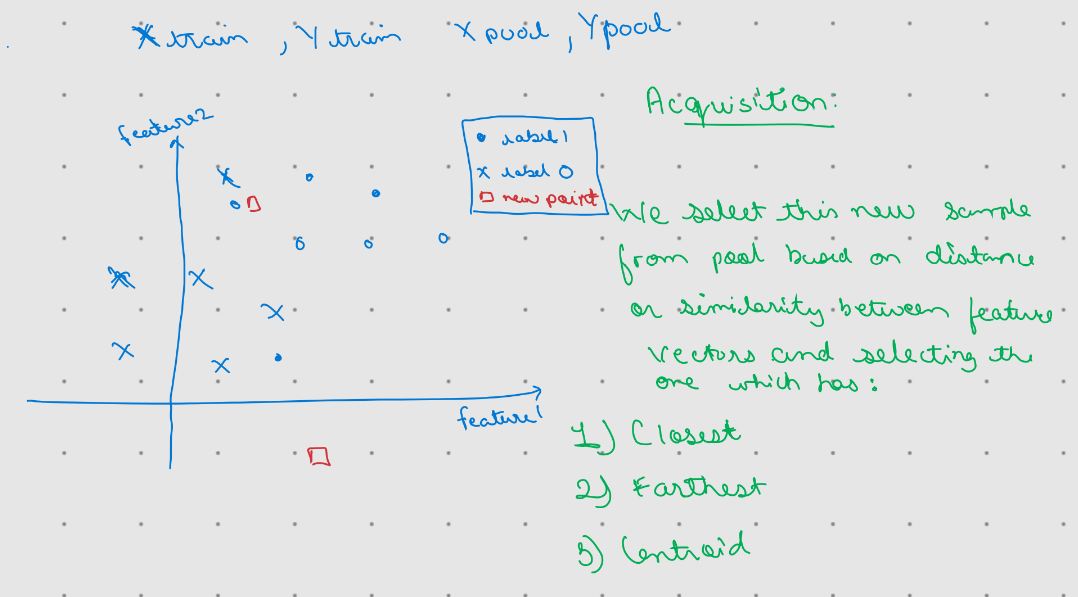
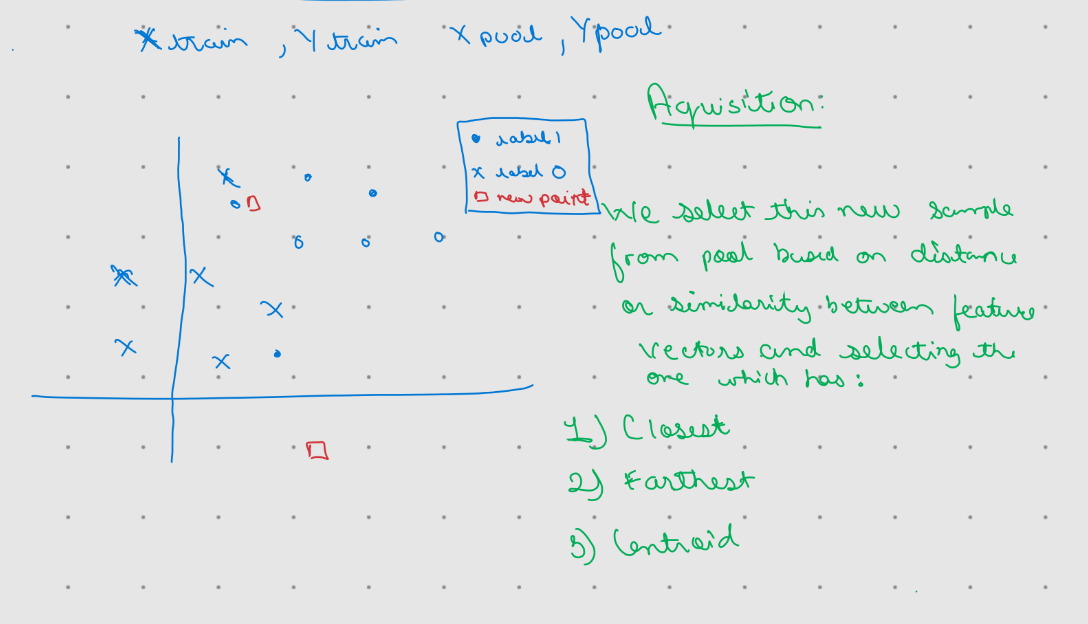

Acquisition function defination

In [18]:
def centroid(model, t_x, p_x, p_y):
    features = model.encoder(t_x.to(device).float())
    centroid_feature = torch.mean(features, dim=0)
    pool_features = model.encoder(p_x.to(device).float())
    distance = torch.cdist(pool_features, centroid_feature.reshape(1, -1))
    n_max_idx = torch.argmax(distance)

    return n_max_idx, p_x[n_max_idx], p_y[n_max_idx]

def farthest(model, t_x, p_x, p_y):
    features = model.encoder(t_x.to(device).float())
    pool_features = model.encoder(p_x.to(device).float())
    distances = torch.cdist(pool_features, features)
    farthest = torch.max(distances, dim=1)
    n_max_idx = torch.argmax(farthest.values)

    return n_max_idx, p_x[n_max_idx], p_y[n_max_idx]

def closest(model, t_x, p_x, p_y):
    features = model.encoder(t_x.to(device).float())
    pool_features = model.encoder(p_x.to(device).float())
    distances = torch.cdist(pool_features, features)
    closest = torch.min(distances, dim=1)
    n_max_idx = torch.argmin(closest.values)

    return n_max_idx, p_x[n_max_idx], p_y[n_max_idx]
    

AL loop

In [23]:
acquisitions_function_dict = {0: centroid, 1: farthest, 2: closest}
epochs = 20
accuracy_list = [[],[],[]]
loss_list = [[],[],[]]
for i in acquisitions_function_dict.keys():
    print(f"-----------------------Running for {acquisitions_function_dict[i]}-----------------------")
    acquisitions_function = acquisitions_function_dict[i]
    model = CNN().to(device) 
    t_x = deepcopy(x_train)
    t_y = deepcopy(y_train)
    p_x = deepcopy(x_pool)
    p_y = deepcopy(y_pool)

    for j in trange(epochs):
        loss_train = train(model, t_x, t_y, epochs=5)
        probs, accuracy, loss = eval(model, p_x, p_y)
        accuracy_list[i].append(accuracy)
        loss_list[i].append(loss)

        ind, x ,y = acquisitions_function(model, t_x, p_x, p_y) # selecting sample from pool

        # adding the selected sample to training set
        t_x = torch.cat((t_x, x.reshape(-1,28,28)), dim=0)
        t_y = torch.cat((t_y, y.reshape(-1)), dim=0)

        # excluding the selected sample from pool
        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)


-----------------------Running for <function centroid at 0x7f6b45f0c8b0>-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736


  5%|▌         | 1/20 [00:00<00:03,  4.78it/s]

Epoch 1, Loss: 0.28359616696834566
Epoch 2, Loss: 0.9279236793518066
Epoch 3, Loss: 0.4684909144882113
Epoch 4, Loss: 0.6297663006465882
Epoch 5, Loss: 0.16512612178921698


 10%|█         | 2/20 [00:00<00:03,  4.56it/s]

Epoch 1, Loss: 0.08282725412330667
Epoch 2, Loss: 0.3224561746234637
Epoch 3, Loss: 0.16004181723110378
Epoch 4, Loss: 0.48032934645501274
Epoch 5, Loss: 0.3683212419806902


 15%|█▌        | 3/20 [00:00<00:03,  4.46it/s]

Epoch 1, Loss: 0.0010401178265238644
Epoch 2, Loss: 2.269908920872895
Epoch 3, Loss: 0.09634841385573216
Epoch 4, Loss: 0.2472064367029816
Epoch 5, Loss: 0.4847015433499889


 20%|██        | 4/20 [00:00<00:03,  4.24it/s]

Epoch 1, Loss: 6.459331649939849e-05
Epoch 2, Loss: 1.2433637495719307
Epoch 3, Loss: 0.0003235002723585012
Epoch 4, Loss: 0.3247864264640157
Epoch 5, Loss: 0.0403615565232025


 25%|██▌       | 5/20 [00:01<00:03,  4.10it/s]

Epoch 1, Loss: 0.0026816654061844
Epoch 2, Loss: 0.15561452123296207
Epoch 3, Loss: 0.005882212769552487
Epoch 4, Loss: 0.16348536736791175
Epoch 5, Loss: 0.576826056465355


 30%|███       | 6/20 [00:01<00:03,  3.96it/s]

Epoch 1, Loss: 0.020616820759459954
Epoch 2, Loss: 0.21489921623611052
Epoch 3, Loss: 3.3117296233032274e-05
Epoch 4, Loss: 1.4891440387010344
Epoch 5, Loss: 0.16265452111622025


 35%|███▌      | 7/20 [00:01<00:03,  3.77it/s]

Epoch 1, Loss: 0.04118290762812011
Epoch 2, Loss: 0.35891319338295297
Epoch 3, Loss: 1.9265615918124912e-05
Epoch 4, Loss: 0.0007645756563069684
Epoch 5, Loss: 0.00022781537576361063


 40%|████      | 8/20 [00:02<00:03,  3.64it/s]

Epoch 1, Loss: 3.9052493582862895e-06
Epoch 2, Loss: 8.956966520745353e-05
Epoch 3, Loss: 0.5194511274802441
Epoch 4, Loss: 0.6689171743191386
Epoch 5, Loss: 0.2765300276059311


 45%|████▌     | 9/20 [00:02<00:03,  3.45it/s]

Epoch 1, Loss: 4.0823027817299013e-08
Epoch 2, Loss: 0.6921171537454709
Epoch 3, Loss: 0.0018797859133254634
Epoch 4, Loss: 2.579368787382652e-09
Epoch 5, Loss: 9.880320505766794e-07


 50%|█████     | 10/20 [00:02<00:03,  3.32it/s]

Epoch 1, Loss: 5.139075544985856e-11
Epoch 2, Loss: 5.901674347757986e-15
Epoch 3, Loss: 3.872893530496192e-05
Epoch 4, Loss: 5.015482999405629e-06
Epoch 5, Loss: 6.30109038565001e-07


 55%|█████▌    | 11/20 [00:03<00:02,  3.17it/s]

Epoch 1, Loss: 8.060712988535776e-19
Epoch 2, Loss: 0.009775611833441724
Epoch 3, Loss: 0.0065710658759764624
Epoch 4, Loss: 2.2142094468692436e-10
Epoch 5, Loss: 9.279333447792537e-09


 60%|██████    | 12/20 [00:03<00:02,  2.94it/s]

Epoch 1, Loss: 5.414770518861637e-11
Epoch 2, Loss: 4.040638756925222e-08
Epoch 3, Loss: 1.6840696236515698
Epoch 4, Loss: 8.944031965959914e-10
Epoch 5, Loss: 0.0017913859170150812


 65%|██████▌   | 13/20 [00:03<00:02,  2.86it/s]

Epoch 1, Loss: 0.029825970126554094
Epoch 2, Loss: 7.012312038890777e-09
Epoch 3, Loss: 0.6785068586629068
Epoch 4, Loss: 0.003447800210020829


 70%|███████   | 14/20 [00:04<00:02,  2.74it/s]

Epoch 5, Loss: 7.126428678966236e-09
Epoch 1, Loss: 1.0941295900817361e-13
Epoch 2, Loss: 4.455620537379037e-16
Epoch 3, Loss: 1.4901084781577518e-10
Epoch 4, Loss: 3.895146352368929e-12
Epoch 5, Loss: 0.05715651178616178


 75%|███████▌  | 15/20 [00:04<00:01,  2.64it/s]

Epoch 1, Loss: 7.683855943984124e-11
Epoch 2, Loss: 1.035488770464532e-14
Epoch 3, Loss: 1.308521644002034e-07
Epoch 4, Loss: 0.0001772349375740625


 80%|████████  | 16/20 [00:05<00:01,  2.56it/s]

Epoch 5, Loss: 5.067974530572605e-20
Epoch 1, Loss: 6.086747169494993
Epoch 2, Loss: 0.09550310969998466
Epoch 3, Loss: 2.1480555069998962e-12
Epoch 4, Loss: 2.6030828515023228e-17
Epoch 5, Loss: 5.023144674301188


 85%|████████▌ | 17/20 [00:05<00:01,  2.44it/s]

Epoch 1, Loss: 3.325516874647593e-06
Epoch 2, Loss: 9.011153201504662e-19
Epoch 3, Loss: 8.12646831964923e-11
Epoch 4, Loss: 8.810194976733343e-18


 90%|█████████ | 18/20 [00:05<00:00,  2.34it/s]

Epoch 5, Loss: 4.54582995074751e-16
Epoch 1, Loss: 9.475395221709806e-21
Epoch 2, Loss: 7.030222364784087e-13
Epoch 3, Loss: 0.03963645345753652
Epoch 4, Loss: 4.60990279249823e-20


 95%|█████████▌| 19/20 [00:06<00:00,  2.27it/s]

Epoch 5, Loss: 4.968023601011267e-07
Epoch 1, Loss: 4.645840895845035e-13
Epoch 2, Loss: 1.6550634406012506e-18
Epoch 3, Loss: 1.7297628042492799
Epoch 4, Loss: 0.511652075726053
Epoch 5, Loss: 0.46423443872944936


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


-----------------------Running for <function farthest at 0x7f6b45f0c790>-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736


  5%|▌         | 1/20 [00:00<00:03,  4.95it/s]

Epoch 1, Loss: 0.28359616696834566
Epoch 2, Loss: 0.9279236793518066
Epoch 3, Loss: 0.4684909144882113
Epoch 4, Loss: 0.6297663006465882
Epoch 5, Loss: 0.16512612178921698


 10%|█         | 2/20 [00:00<00:03,  4.78it/s]

Epoch 1, Loss: 0.16578852532984456
Epoch 2, Loss: 0.40730796427730337
Epoch 3, Loss: 0.5146988108172081
Epoch 4, Loss: 0.6866877533805867
Epoch 5, Loss: 0.9582888945040698


 15%|█▌        | 3/20 [00:00<00:03,  4.57it/s]

Epoch 1, Loss: 0.010826415737873669
Epoch 2, Loss: 3.2399707607905635
Epoch 3, Loss: 0.04401043395325287
Epoch 4, Loss: 0.9070812596972766
Epoch 5, Loss: 1.149379917825302


 20%|██        | 4/20 [00:00<00:03,  4.33it/s]

Epoch 1, Loss: 0.09312114229875822
Epoch 2, Loss: 1.6619181268913827
Epoch 3, Loss: 0.036241800515455225
Epoch 4, Loss: 0.10069888416182948
Epoch 5, Loss: 0.23339998423307406


 25%|██▌       | 5/20 [00:01<00:03,  4.12it/s]

Epoch 1, Loss: 1.0700067617844613e-05
Epoch 2, Loss: 2.662905155556584
Epoch 3, Loss: 0.019481418038417672
Epoch 4, Loss: 0.004350042085156424
Epoch 5, Loss: 0.15923708651522853


 30%|███       | 6/20 [00:01<00:03,  3.94it/s]

Epoch 1, Loss: 2.0380461875737705e-06
Epoch 2, Loss: 0.2877755758381475
Epoch 3, Loss: 0.008323445822798994
Epoch 4, Loss: 0.00016659083798913342
Epoch 5, Loss: 0.05453162825935991


 35%|███▌      | 7/20 [00:01<00:03,  3.75it/s]

Epoch 1, Loss: 0.01099619910978263
Epoch 2, Loss: 0.00037943410974423925
Epoch 3, Loss: 0.5464298386638459
Epoch 4, Loss: 0.058013055317705516
Epoch 5, Loss: 1.1838190987153874


 40%|████      | 8/20 [00:02<00:03,  3.54it/s]

Epoch 1, Loss: 8.879248599963018e-10
Epoch 2, Loss: 0.00032965400090727146
Epoch 3, Loss: 5.547259844070721e-05
Epoch 4, Loss: 5.1918243151334055e-05
Epoch 5, Loss: 0.055880038375808815


 45%|████▌     | 9/20 [00:02<00:03,  3.39it/s]

Epoch 1, Loss: 3.0001708690834555e-11
Epoch 2, Loss: 0.34995215434367277
Epoch 3, Loss: 0.000551797590682707
Epoch 4, Loss: 3.3685180088239036e-06
Epoch 5, Loss: 1.904398540394009e-05


 50%|█████     | 10/20 [00:02<00:03,  3.25it/s]

Epoch 1, Loss: 7.943927293798176e-06
Epoch 2, Loss: 6.744009234875493e-06
Epoch 3, Loss: 4.520019196394564e-17
Epoch 4, Loss: 0.6061141844472948
Epoch 5, Loss: 0.04617436792380471


 55%|█████▌    | 11/20 [00:03<00:02,  3.08it/s]

Epoch 1, Loss: 0.3368801435033486
Epoch 2, Loss: 0.001341732021833067
Epoch 3, Loss: 5.56312257478305e-08
Epoch 4, Loss: 1.2582683464716143e-09
Epoch 5, Loss: 7.029334591102842e-08


 60%|██████    | 12/20 [00:03<00:02,  2.96it/s]

Epoch 1, Loss: 3.922696781898438e-14
Epoch 2, Loss: 0.00016962637900427935
Epoch 3, Loss: 3.158286179836645e-11
Epoch 4, Loss: 0.2667919021568993
Epoch 5, Loss: 2.6645505371129026e-06


 65%|██████▌   | 13/20 [00:03<00:02,  2.82it/s]

Epoch 1, Loss: 7.829254465588632e-12
Epoch 2, Loss: 0.005836620514268356
Epoch 3, Loss: 0.06407161946158624
Epoch 4, Loss: 2.42482652002442e-08


 70%|███████   | 14/20 [00:04<00:02,  2.71it/s]

Epoch 5, Loss: 4.020118693330749e-06
Epoch 1, Loss: 1.7726361955317118e-15
Epoch 2, Loss: 2.1445241774280498e-14
Epoch 3, Loss: 9.738534139609436e-11
Epoch 4, Loss: 1.0506589879640522
Epoch 5, Loss: 0.5064030223539145


 75%|███████▌  | 15/20 [00:04<00:01,  2.62it/s]

Epoch 1, Loss: 0.38504681021605736
Epoch 2, Loss: 4.260337012543326e-06
Epoch 3, Loss: 0.009008048499087233
Epoch 4, Loss: 1.0601367438177584e-05


 80%|████████  | 16/20 [00:05<00:01,  2.52it/s]

Epoch 5, Loss: 0.5181529396463669
Epoch 1, Loss: 3.7455558637970166e-17
Epoch 2, Loss: 0.005574045431992719
Epoch 3, Loss: 0.4620212657526827
Epoch 4, Loss: 7.184837026005533e-05


 85%|████████▌ | 17/20 [00:05<00:01,  2.43it/s]

Epoch 5, Loss: 7.068485700298715e-05
Epoch 1, Loss: 6.184920908519382e-19
Epoch 2, Loss: 9.14363728893061e-06
Epoch 3, Loss: 3.267065136923655e-11
Epoch 4, Loss: 4.060631955307179e-07


 90%|█████████ | 18/20 [00:05<00:00,  2.33it/s]

Epoch 5, Loss: 2.839444241400349e-11
Epoch 1, Loss: 7.699668269940564e-16
Epoch 2, Loss: 4.116538354905079e-13
Epoch 3, Loss: 3.8447720803548835e-08
Epoch 4, Loss: 7.308617158079983e-23


 95%|█████████▌| 19/20 [00:06<00:00,  2.27it/s]

Epoch 5, Loss: 0.3191435770554976
Epoch 1, Loss: 2.1017243960768416e-16
Epoch 2, Loss: 3.255561085969806e-11
Epoch 3, Loss: 9.839988724696892e-11
Epoch 4, Loss: 6.704770835644938e-05
Epoch 5, Loss: 4.354255257774739


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


-----------------------Running for <function closest at 0x7f6b45f0c670>-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736


 10%|█         | 2/20 [00:00<00:03,  4.85it/s]

Epoch 1, Loss: 0.48780956864356995
Epoch 2, Loss: 0.600804303586483
Epoch 3, Loss: 0.31071825288236143
Epoch 4, Loss: 1.0022339679300785
Epoch 5, Loss: 0.173796921223402
Epoch 1, Loss: 0.037815049601097904
Epoch 2, Loss: 0.16779804496521442
Epoch 3, Loss: 0.0751168963033706
Epoch 4, Loss: 0.09772860926265518
Epoch 5, Loss: 0.19202315864580063


 15%|█▌        | 3/20 [00:00<00:03,  4.61it/s]

Epoch 1, Loss: 0.03633743588625293
Epoch 2, Loss: 0.15227049667503575
Epoch 3, Loss: 0.0006745052941466513
Epoch 4, Loss: 0.0019418136259576255
Epoch 5, Loss: 0.00046751409809075994


 20%|██        | 4/20 [00:00<00:03,  4.33it/s]

Epoch 1, Loss: 4.919784259982407e-06
Epoch 2, Loss: 0.003274412972167795
Epoch 3, Loss: 4.343180535215652e-06
Epoch 4, Loss: 0.004326878678599488
Epoch 5, Loss: 12.506538937333971


 25%|██▌       | 5/20 [00:01<00:03,  4.17it/s]

Epoch 1, Loss: 1.2105437023161395e-10
Epoch 2, Loss: 0.06569462140214138
Epoch 3, Loss: 0.00032504640349147407
Epoch 4, Loss: 8.21245395464245e-06
Epoch 5, Loss: 5.4634859180138465e-05


 30%|███       | 6/20 [00:01<00:03,  4.03it/s]

Epoch 1, Loss: 0.0002749109717944482
Epoch 2, Loss: 5.179579218483887e-06
Epoch 3, Loss: 0.0005141872105261319
Epoch 4, Loss: 2.1143470854212422e-05
Epoch 5, Loss: 5.290064122007098e-05


 35%|███▌      | 7/20 [00:01<00:03,  3.79it/s]

Epoch 1, Loss: 1.733955468875172e-07
Epoch 2, Loss: 0.0007878388113340407
Epoch 3, Loss: 1.8505055279108286e-24
Epoch 4, Loss: 1.8419645398766576e-05
Epoch 5, Loss: 1.0927487598185535e-08


 40%|████      | 8/20 [00:02<00:03,  3.62it/s]

Epoch 1, Loss: 5.350187427822985e-19
Epoch 2, Loss: 2.518075689667472e-21
Epoch 3, Loss: 2.2234969158635137e-23
Epoch 4, Loss: 3.047092968930821e-13
Epoch 5, Loss: 2.0730550835515492e-06


 45%|████▌     | 9/20 [00:02<00:03,  3.44it/s]

Epoch 1, Loss: 1.7293959400370103e-06
Epoch 2, Loss: 7.776823255277628e-19
Epoch 3, Loss: 3.026087912215959e-07
Epoch 4, Loss: 1.0106122667472613e-05
Epoch 5, Loss: 7.152871096248165e-06


 50%|█████     | 10/20 [00:02<00:03,  3.27it/s]

Epoch 1, Loss: 1.848434415678017e-20
Epoch 2, Loss: 2.5484666945752757e-19
Epoch 3, Loss: 6.947065335883262e-23
Epoch 4, Loss: 0.37303959006678117
Epoch 5, Loss: 0.003383638608769478


 55%|█████▌    | 11/20 [00:03<00:02,  3.14it/s]

Epoch 1, Loss: 1.187110780046891e-10
Epoch 2, Loss: 2.620242830579193e-11
Epoch 3, Loss: 9.256556948189269e-18
Epoch 4, Loss: 1.3933638162895307e-17
Epoch 5, Loss: 1.589459164582728e-07


 60%|██████    | 12/20 [00:03<00:02,  3.01it/s]

Epoch 1, Loss: 1.267606952152821e-21
Epoch 2, Loss: 2.8268417776416432e-15
Epoch 3, Loss: 1.621141554537321e-09
Epoch 4, Loss: 0.0006808522157371062
Epoch 5, Loss: 1.1445459164807933e-11


 65%|██████▌   | 13/20 [00:03<00:02,  2.88it/s]

Epoch 1, Loss: 4.878685399106853e-11
Epoch 2, Loss: 0.36641543051795833
Epoch 3, Loss: 7.9239650992404e-07
Epoch 4, Loss: 2.5699856307497455e-25


 70%|███████   | 14/20 [00:04<00:02,  2.78it/s]

Epoch 5, Loss: 3.2256719565473074e-07
Epoch 1, Loss: 1.3135406106928365e-28
Epoch 2, Loss: 0.0006777659162051164
Epoch 3, Loss: 0.16501192252076355
Epoch 4, Loss: 8.21320617089731e-07
Epoch 5, Loss: 0.0002824140904952613


 75%|███████▌  | 15/20 [00:04<00:01,  2.66it/s]

Epoch 1, Loss: 1.882254077177777e-08
Epoch 2, Loss: 0.0006355444753640576
Epoch 3, Loss: 1.50874400190315e-12
Epoch 4, Loss: 4.499235136503815e-09


 80%|████████  | 16/20 [00:05<00:01,  2.45it/s]

Epoch 5, Loss: 0.050185090617129675
Epoch 1, Loss: 2.9981859038762393e-27
Epoch 2, Loss: 9.44996023486227e-18
Epoch 3, Loss: 5.223244272656302e-08
Epoch 4, Loss: 0.0


 85%|████████▌ | 17/20 [00:05<00:01,  2.41it/s]

Epoch 5, Loss: 1.2931761320547312e-24
Epoch 1, Loss: 0.0
Epoch 2, Loss: 7.276881885227434e-29
Epoch 3, Loss: 1.2783865236240797e-11
Epoch 4, Loss: 6.851249494362296e-20
Epoch 5, Loss: 0.0


 90%|█████████ | 18/20 [00:05<00:00,  2.34it/s]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 2.8228133603512273e-30
Epoch 3, Loss: 2.6554491239227778e-17
Epoch 4, Loss: 1.3061918127648168e-36


 95%|█████████▌| 19/20 [00:06<00:00,  2.27it/s]

Epoch 5, Loss: 3.3776527222164654e-38
Epoch 1, Loss: 0.0
Epoch 2, Loss: 7.102653325020685e-35
Epoch 3, Loss: 8.074486578210209e-18
Epoch 4, Loss: 0.0004931058625293914
Epoch 5, Loss: 2.59150666530015e-08


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


AL for random sampling

In [24]:
import numpy as np
# np.random.seed(42)
random_losses = []
random_accuracy = []
epochs = 20
random_run = 5
for i in range(random_run): # n random runs 
    r_losses = []
    r_accuracy = []
    print('------------------------------Random Run ',i+1 ,'------------------------------')
    
    model = CNN().to(device)
    t_x = deepcopy(x_train)
    t_y = deepcopy(y_train)
    p_x = deepcopy(x_pool)
    p_y = deepcopy(y_pool)

    for j in trange(epochs):
        loss_train = train(model, t_x, t_y, epochs=15)
        probs, accuracy, loss = eval(model, p_x, p_y)

        r_losses.append(loss)
        r_accuracy.append(accuracy) 
        ind = np.random.randint(0, len(p_x))
        x, y = p_x[ind], p_y[ind] 

        t_x = torch.cat((t_x, x.reshape(-1, 28, 28)), dim=0)
        t_y = torch.cat((t_y, y.reshape(-1)), dim=0)

        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)

    
    random_losses.append(r_losses)
    random_accuracy.append(r_accuracy)

------------------------------Random Run  1 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736
Epoch 6, Loss: 0.7154399631544948
Epoch 7, Loss: 0.5227866172790527
Epoch 8, Loss: 0.4448691722936928
Epoch 9, Loss: 0.5810829382389784
Epoch 10, Loss: 0.2527669067494571
Epoch 11, Loss: 0.23033996857702732
Epoch 12, Loss: 0.5306506678462029
Epoch 13, Loss: 0.1328460080549121
Epoch 14, Loss: 0.1919356225989759
Epoch 15, Loss: 0.6668191400822252


  5%|▌         | 1/20 [00:00<00:05,  3.45it/s]

Epoch 1, Loss: 0.05297744814306497
Epoch 2, Loss: 0.5367253731004894
Epoch 3, Loss: 0.019337481015827506
Epoch 4, Loss: 0.697475204989314
Epoch 5, Loss: 0.01572951112902956
Epoch 6, Loss: 0.00752774397842586
Epoch 7, Loss: 0.16222098995931447
Epoch 8, Loss: 0.20951162909623236
Epoch 9, Loss: 0.009868245746474713
Epoch 10, Loss: 0.013927788440926037
Epoch 11, Loss: 0.227218502695996
Epoch 12, Loss: 0.09043946709693955
Epoch 13, Loss: 0.0009138750552665442
Epoch 14, Loss: 0.055088139825966206
Epoch 15, Loss: 0.06002319483086467


 10%|█         | 2/20 [00:00<00:05,  3.09it/s]

Epoch 1, Loss: 0.2641276956031409
Epoch 2, Loss: 0.007285571635411732
Epoch 3, Loss: 0.06376945281870879
Epoch 4, Loss: 0.7837439649494348
Epoch 5, Loss: 0.4421461544071552
Epoch 6, Loss: 0.000599176346099739
Epoch 7, Loss: 0.01712680101263686
Epoch 8, Loss: 0.2655731557960432
Epoch 9, Loss: 0.019605202827809382
Epoch 10, Loss: 0.0017500371929296914
Epoch 11, Loss: 0.009786863253490688
Epoch 12, Loss: 0.004426876866394498
Epoch 13, Loss: 0.06164711655886398
Epoch 14, Loss: 4.750847814231444e-05
Epoch 15, Loss: 0.00020198750525679543


 15%|█▌        | 3/20 [00:01<00:06,  2.81it/s]

Epoch 1, Loss: 5.37763979995276e-05
Epoch 2, Loss: 0.9896756825249541
Epoch 3, Loss: 5.745990501129783e-05
Epoch 4, Loss: 0.016890839337096914
Epoch 5, Loss: 0.0018765964466582424
Epoch 6, Loss: 0.08173754653581763
Epoch 7, Loss: 0.0017868188175437386
Epoch 8, Loss: 0.6924232167285865
Epoch 9, Loss: 1.846999711980451e-05
Epoch 10, Loss: 0.0009016870874428865
Epoch 11, Loss: 0.14614318730895498


 20%|██        | 4/20 [00:01<00:06,  2.60it/s]

Epoch 12, Loss: 0.004087964039480799
Epoch 13, Loss: 0.006050297130842339
Epoch 14, Loss: 0.0068186087453341315
Epoch 15, Loss: 0.5877678262526079
Epoch 1, Loss: 12.500000095643184
Epoch 2, Loss: 0.00015242739350091
Epoch 3, Loss: 0.004695824118554055
Epoch 4, Loss: 6.930627114343235e-05
Epoch 5, Loss: 1.5732751503243962
Epoch 6, Loss: 1.4072404196502882e-07
Epoch 7, Loss: 0.2516931837934167
Epoch 8, Loss: 6.601637601638915e-06
Epoch 9, Loss: 0.0015105852903413534
Epoch 10, Loss: 1.8614363329244425e-05
Epoch 11, Loss: 0.00033056618521842894
Epoch 12, Loss: 0.4106255034631917
Epoch 13, Loss: 0.965464582156421
Epoch 14, Loss: 0.06067801199868006
Epoch 15, Loss: 0.0003485834855538883


 25%|██▌       | 5/20 [00:01<00:06,  2.42it/s]

Epoch 1, Loss: 0.13264260240921202
Epoch 2, Loss: 0.005205957886714074
Epoch 3, Loss: 9.435991804088229e-06
Epoch 4, Loss: 5.118794893546292e-06
Epoch 5, Loss: 1.0994479610840907e-07
Epoch 6, Loss: 2.8990270040374135e-07
Epoch 7, Loss: 0.0564504562182294
Epoch 8, Loss: 0.00038049200320566123
Epoch 9, Loss: 0.6782050102201574
Epoch 10, Loss: 0.007476613313280686
Epoch 11, Loss: 0.12869850705034483
Epoch 12, Loss: 1.3244787225949769e-05
Epoch 13, Loss: 0.00215091616561949
Epoch 14, Loss: 0.0296610525918892
Epoch 15, Loss: 2.2958740440238836e-05


 30%|███       | 6/20 [00:02<00:06,  2.22it/s]

Epoch 1, Loss: 2.480323596014411e-06
Epoch 2, Loss: 0.00011817640626189171
Epoch 3, Loss: 3.883191167658315e-15
Epoch 4, Loss: 8.800180586243286e-06
Epoch 5, Loss: 4.03053228898895e-10
Epoch 6, Loss: 5.352282097403264e-10
Epoch 7, Loss: 6.084066806763043e-16
Epoch 8, Loss: 0.0001722880297165831
Epoch 9, Loss: 2.6272019766812224e-06
Epoch 10, Loss: 0.24130413295842512
Epoch 11, Loss: 12.010955715195296
Epoch 12, Loss: 1.4305124977911385e-07
Epoch 13, Loss: 1.9853394389771388
Epoch 14, Loss: 1.1864848137155213


 35%|███▌      | 7/20 [00:03<00:06,  2.00it/s]

Epoch 15, Loss: 5.434300826943215e-05
Epoch 1, Loss: 0.002923147128224886
Epoch 2, Loss: 0.32882439846843403
Epoch 3, Loss: 1.1783467768127588e-09
Epoch 4, Loss: 1.2588800756086815e-05
Epoch 5, Loss: 3.2103131055206514e-09
Epoch 6, Loss: 0.17829647740325805
Epoch 7, Loss: 1.014078411524417e-10
Epoch 8, Loss: 1.6984337166972303
Epoch 9, Loss: 1.0592660041930253
Epoch 10, Loss: 3.329329637616879e-08
Epoch 11, Loss: 3.142913983273121e-07
Epoch 12, Loss: 2.0411148596618163e-05
Epoch 13, Loss: 0.0006178925812605608
Epoch 14, Loss: 6.119559759533254e-08
Epoch 15, Loss: 0.014198859679411336


 40%|████      | 8/20 [00:03<00:06,  1.87it/s]

Epoch 1, Loss: 0.003351147613965878
Epoch 2, Loss: 0.014352239477360607
Epoch 3, Loss: 0.000631524637977462
Epoch 4, Loss: 3.890825018727401e-07
Epoch 5, Loss: 0.2421866688177867
Epoch 6, Loss: 0.02416576971535146
Epoch 7, Loss: 0.018410739799343167
Epoch 8, Loss: 7.239932648551488e-17
Epoch 9, Loss: 0.6933112031171987
Epoch 10, Loss: 5.939699196831961e-05
Epoch 11, Loss: 0.20728621880223339
Epoch 12, Loss: 2.1880187764429066e-09


 45%|████▌     | 9/20 [00:04<00:06,  1.75it/s]

Epoch 13, Loss: 5.6427632345497666e-06
Epoch 14, Loss: 1.367167388750805e-11
Epoch 15, Loss: 7.435825122264201e-19
Epoch 1, Loss: 2.7862064419393025e-18
Epoch 2, Loss: 1.0672141588651216
Epoch 3, Loss: 9.170165900029145e-09
Epoch 4, Loss: 0.0014106000837715382
Epoch 5, Loss: 0.0004873671169517618
Epoch 6, Loss: 6.14642514334603e-13
Epoch 7, Loss: 1.422621510683456e-15
Epoch 8, Loss: 0.0680310181303614
Epoch 9, Loss: 1.2270261027073626
Epoch 10, Loss: 1.83398928864221e-08
Epoch 11, Loss: 6.012908857877545e-19
Epoch 12, Loss: 4.7757831817863615e-27


 50%|█████     | 10/20 [00:04<00:06,  1.66it/s]

Epoch 13, Loss: 6.798391516965169e-05
Epoch 14, Loss: 0.5411815643311021
Epoch 15, Loss: 2.195415883835047e-06
Epoch 1, Loss: 2.2059482665400084e-06
Epoch 2, Loss: 0.4934249264854246
Epoch 3, Loss: 7.790552708143204e-12
Epoch 4, Loss: 0.9624292039928791
Epoch 5, Loss: 2.5776914183576695e-12
Epoch 6, Loss: 1.3539050705909815e-06
Epoch 7, Loss: 0.45524975235236426
Epoch 8, Loss: 5.517900200247963e-06
Epoch 9, Loss: 0.6149188353267122
Epoch 10, Loss: 0.0013361380898319847
Epoch 11, Loss: 0.09528664146523054
Epoch 12, Loss: 1.6337519160517785e-10
Epoch 13, Loss: 7.20738731953933e-10
Epoch 14, Loss: 1.0415478124996251e-08
Epoch 15, Loss: 7.313536750121914e-05


 55%|█████▌    | 11/20 [00:05<00:05,  1.56it/s]

Epoch 1, Loss: 2.027996647380639e-09
Epoch 2, Loss: 1.6371610402149624e-06
Epoch 3, Loss: 6.50251104221206e-07
Epoch 4, Loss: 2.900443086464751e-13
Epoch 5, Loss: 1.9808794370296785e-13
Epoch 6, Loss: 1.3626709975826068e-14
Epoch 7, Loss: 0.0008076520025909697
Epoch 8, Loss: 0.0001962177935694998
Epoch 9, Loss: 1.631174311325826e-19
Epoch 10, Loss: 7.776718276847336e-17
Epoch 11, Loss: 2.0172683386753087
Epoch 12, Loss: 0.012304405518204574
Epoch 13, Loss: 2.728394262880718e-26
Epoch 14, Loss: 0.6429795375656492
Epoch 15, Loss: 6.666666666666667


 60%|██████    | 12/20 [00:06<00:05,  1.45it/s]

Epoch 1, Loss: 0.003291283734142782
Epoch 2, Loss: 0.5778424739837646
Epoch 3, Loss: 0.00038994729402477694
Epoch 4, Loss: 0.31144272647380566
Epoch 5, Loss: 2.5281406452290484e-18
Epoch 6, Loss: 2.694693760143546e-14
Epoch 7, Loss: 2.5261812221413306e-24
Epoch 8, Loss: 5.294290411265713e-13
Epoch 9, Loss: 5.5423872781243784e-18
Epoch 10, Loss: 6.292649162969441e-19
Epoch 11, Loss: 5.827422017588555e-16
Epoch 12, Loss: 1.4528801557391254e-06
Epoch 13, Loss: 0.0001255938404949577
Epoch 14, Loss: 3.407065162818642e-15
Epoch 15, Loss: 3.5246620692200056e-20


 65%|██████▌   | 13/20 [00:07<00:05,  1.37it/s]

Epoch 1, Loss: 3.449401233973057e-19
Epoch 2, Loss: 7.595683751830829e-16
Epoch 3, Loss: 4.740037204100712e-12
Epoch 4, Loss: 1.5385504076306007e-17
Epoch 5, Loss: 7.302639670397145e-18
Epoch 6, Loss: 3.699607684318903e-23
Epoch 7, Loss: 4.731350159468151e-16
Epoch 8, Loss: 5.0255187388481335e-22
Epoch 9, Loss: 1.1520574290720524e-11
Epoch 10, Loss: 2.4035780961146537e-17
Epoch 11, Loss: 3.5741111466503594e-07
Epoch 12, Loss: 0.16752854960641878
Epoch 13, Loss: 1.0361918281482092
Epoch 14, Loss: 0.8970140028066828
Epoch 15, Loss: 0.40909651548735826


 70%|███████   | 14/20 [00:08<00:04,  1.29it/s]

Epoch 1, Loss: 4.495479147054525e-05
Epoch 2, Loss: 0.1688778530829757
Epoch 3, Loss: 0.0007801932072899373
Epoch 4, Loss: 0.011121968305054915
Epoch 5, Loss: 3.8076461583943415e-18
Epoch 6, Loss: 3.2541857699739498e-21
Epoch 7, Loss: 9.862028024815831e-21
Epoch 8, Loss: 8.429201781012894e-11
Epoch 9, Loss: 4.268917999687743e-18
Epoch 10, Loss: 3.1135973257431484e-19
Epoch 11, Loss: 4.7054410476091466e-14
Epoch 12, Loss: 6.294256131630699e-13
Epoch 13, Loss: 1.8924925062391493
Epoch 14, Loss: 2.5601934525148366e-14
Epoch 15, Loss: 4.541423219167783e-14


 75%|███████▌  | 15/20 [00:09<00:04,  1.22it/s]

Epoch 1, Loss: 1.54433045013073e-14
Epoch 2, Loss: 0.20893152136551707
Epoch 3, Loss: 1.33485775354866e-22
Epoch 4, Loss: 1.0657309421466342e-18
Epoch 5, Loss: 3.2755825863159627e-23
Epoch 6, Loss: 1.1624678951240118e-26
Epoch 7, Loss: 2.07365090252563e-17
Epoch 8, Loss: 6.27417388219145e-09
Epoch 9, Loss: 0.047947820864225686
Epoch 10, Loss: 8.218788612325051e-35
Epoch 11, Loss: 1.055146765205189e-36
Epoch 12, Loss: 1.3882359956440173
Epoch 13, Loss: 1.3683249824925472
Epoch 14, Loss: 10.526768525022083
Epoch 15, Loss: 0.3507592964483748


 80%|████████  | 16/20 [00:10<00:03,  1.16it/s]

Epoch 1, Loss: 5.000002514672462
Epoch 2, Loss: 0.04761114120553172
Epoch 3, Loss: 1.4998125076293944
Epoch 4, Loss: 1.5642704968620122e-05
Epoch 5, Loss: 1.6592213544022458e-18
Epoch 6, Loss: 1.0643570501127999e-13
Epoch 7, Loss: 6.017922237121821e-11
Epoch 8, Loss: 9.651289966271126e-20
Epoch 9, Loss: 9.143125553441924e-23
Epoch 10, Loss: 1.163361937683805e-20
Epoch 11, Loss: 8.541850189728408e-27
Epoch 12, Loss: 2.3245866032118196e-07
Epoch 13, Loss: 6.256908619969114e-15
Epoch 14, Loss: 3.576280107608909e-08
Epoch 15, Loss: 5.960465188082968e-09


 85%|████████▌ | 17/20 [00:11<00:02,  1.10it/s]

Epoch 1, Loss: 2.9698237495395436e-26
Epoch 2, Loss: 6.93735048903917e-06
Epoch 3, Loss: 0.21570369175502233
Epoch 4, Loss: 1.325646393173139e-17
Epoch 5, Loss: 3.2139217048829936e-29
Epoch 6, Loss: 4.761904761904762
Epoch 7, Loss: 2.536210097841547e-35
Epoch 8, Loss: 3.9831734619331475e-32
Epoch 9, Loss: 2.2989568917919805e-29
Epoch 10, Loss: 6.1242266381136586e-27
Epoch 11, Loss: 1.4521879588540494e-27
Epoch 12, Loss: 4.093737898301435e-31
Epoch 13, Loss: 1.4459524692028021e-24
Epoch 14, Loss: 6.680923154864067e-25
Epoch 15, Loss: 3.789114412849967e-29


 90%|█████████ | 18/20 [00:12<00:01,  1.05it/s]

Epoch 1, Loss: 4.165177512198706e-26
Epoch 2, Loss: 3.4268028952858667
Epoch 3, Loss: 3.7898085869074463e-13
Epoch 4, Loss: 1.0943771294747798e-25
Epoch 5, Loss: 1.020268918118291e-19
Epoch 6, Loss: 2.596670642201553e-22
Epoch 7, Loss: 9.178963528649383e-09
Epoch 8, Loss: 0.0
Epoch 9, Loss: 4.545454545454546
Epoch 10, Loss: 5.023565044361166
Epoch 11, Loss: 0.28539307519254103
Epoch 12, Loss: 0.7269616560502485
Epoch 13, Loss: 5.789056853145996e-06
Epoch 14, Loss: 4.022595745117358e-05
Epoch 15, Loss: 0.277203569559768


 95%|█████████▌| 19/20 [00:13<00:00,  1.02it/s]

Epoch 1, Loss: 1.923177487602064e-06
Epoch 2, Loss: 1.8845077973962337e-12
Epoch 3, Loss: 0.04772814978723942
Epoch 4, Loss: 0.5636602070020593
Epoch 5, Loss: 2.9755785983610572e-25
Epoch 6, Loss: 9.913631347425253e-17
Epoch 7, Loss: 1.0000819797899002e-10
Epoch 8, Loss: 2.041519359361999e-09
Epoch 9, Loss: 0.21939242405424064
Epoch 10, Loss: 0.49659362046614935
Epoch 11, Loss: 1.1543898687222748e-11
Epoch 12, Loss: 1.4192088848926935e-22
Epoch 13, Loss: 4.355232330768005
Epoch 14, Loss: 7.111573519980529e-19
Epoch 15, Loss: 3.179025267822013e-07


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


------------------------------Random Run  2 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736
Epoch 6, Loss: 0.7154399631544948
Epoch 7, Loss: 0.5227866172790527
Epoch 8, Loss: 0.4448691722936928
Epoch 9, Loss: 0.5810829382389784
Epoch 10, Loss: 0.2527669067494571
Epoch 11, Loss: 0.23033996857702732
Epoch 12, Loss: 0.5306506678462029
Epoch 13, Loss: 0.1328460080549121
Epoch 14, Loss: 0.1919356225989759
Epoch 15, Loss: 0.6668191400822252


  5%|▌         | 1/20 [00:00<00:05,  3.40it/s]

Epoch 1, Loss: 0.5331525633111596
Epoch 2, Loss: 0.0628103637136519
Epoch 3, Loss: 0.011031203460879624
Epoch 4, Loss: 0.9014620034024119
Epoch 5, Loss: 0.05891025839373469
Epoch 6, Loss: 0.03168753865174949
Epoch 7, Loss: 0.05330369239673018
Epoch 8, Loss: 0.011718836252111942
Epoch 9, Loss: 0.006515280430903658
Epoch 10, Loss: 0.006732749233469804
Epoch 11, Loss: 0.16762269829632714
Epoch 12, Loss: 0.03732937296226737
Epoch 13, Loss: 0.0009727215729071759
Epoch 14, Loss: 0.0027988347039354265
Epoch 15, Loss: 0.13170943283048472


 10%|█         | 2/20 [00:00<00:05,  3.08it/s]

Epoch 1, Loss: 0.08992684947027858
Epoch 2, Loss: 0.0016729466966895294
Epoch 3, Loss: 0.5347826481618775
Epoch 4, Loss: 1.498047524400161
Epoch 5, Loss: 0.04989287776853265
Epoch 6, Loss: 0.002212510978201484
Epoch 7, Loss: 0.0013519079176281441
Epoch 8, Loss: 0.0007425803057241609
Epoch 9, Loss: 0.0010179315375277536
Epoch 10, Loss: 0.0002972839502722498
Epoch 11, Loss: 0.00247714393555191
Epoch 12, Loss: 0.00013401334999466977
Epoch 13, Loss: 0.0450166554429309
Epoch 14, Loss: 0.000734717840495603
Epoch 15, Loss: 3.859446530665722e-05


 15%|█▌        | 3/20 [00:01<00:06,  2.73it/s]

Epoch 1, Loss: 0.005279658670418923
Epoch 2, Loss: 0.23598300734789665
Epoch 3, Loss: 0.013227580770399674
Epoch 4, Loss: 6.94763435616335e-09
Epoch 5, Loss: 2.573741669631104e-06
Epoch 6, Loss: 0.01120331307959485
Epoch 7, Loss: 0.006092542508165023
Epoch 8, Loss: 0.005948078975452804
Epoch 9, Loss: 0.18590268846004904
Epoch 10, Loss: 0.0014844546467887073


 20%|██        | 4/20 [00:01<00:06,  2.60it/s]

Epoch 11, Loss: 2.291706950611477
Epoch 12, Loss: 0.007631400749757322
Epoch 13, Loss: 0.0049646148711173866
Epoch 14, Loss: 0.7404020049156576
Epoch 15, Loss: 0.012527405500545033
Epoch 1, Loss: 0.5865854808629614
Epoch 2, Loss: 0.0017104525341806731
Epoch 3, Loss: 4.939342044319329e-06
Epoch 4, Loss: 0.05866836998403032
Epoch 5, Loss: 0.02320209721451209
Epoch 6, Loss: 0.0003283084581512351
Epoch 7, Loss: 1.1205199691205485e-06
Epoch 8, Loss: 0.0006664487225540927
Epoch 9, Loss: 1.8662061351061183e-05
Epoch 10, Loss: 0.00033704381626684083
Epoch 11, Loss: 8.960916431510945e-06
Epoch 12, Loss: 4.96101737409507e-07
Epoch 13, Loss: 5.848479546131099e-05
Epoch 14, Loss: 4.1725551988281174e-07
Epoch 15, Loss: 0.00011154533576520774


 25%|██▌       | 5/20 [00:01<00:06,  2.42it/s]

Epoch 1, Loss: 0.0010379958671033365
Epoch 2, Loss: 0.018982960172091598
Epoch 3, Loss: 1.1468871443179427
Epoch 4, Loss: 1.470493702877817e-08
Epoch 5, Loss: 1.7845190402030275e-06
Epoch 6, Loss: 0.01739124203374216
Epoch 7, Loss: 0.00023107721673932215
Epoch 8, Loss: 3.46548686998322e-05
Epoch 9, Loss: 0.00044378376272186354
Epoch 10, Loss: 2.762847715499043e-06
Epoch 11, Loss: 2.063098967023613
Epoch 12, Loss: 1.163107229637308e-05
Epoch 13, Loss: 1.1129446310653578e-07
Epoch 14, Loss: 0.6947786657739029
Epoch 15, Loss: 0.4523545848207083


 30%|███       | 6/20 [00:02<00:06,  2.24it/s]

Epoch 1, Loss: 1.1327378387419889
Epoch 2, Loss: 1.4254760619241421e-07
Epoch 3, Loss: 0.6687012121874248
Epoch 4, Loss: 0.00021891316435279388
Epoch 5, Loss: 1.6842664179105017e-05
Epoch 6, Loss: 9.679712877270162e-05
Epoch 7, Loss: 0.1632802510616443
Epoch 8, Loss: 0.002915439974532692
Epoch 9, Loss: 0.09117861840175448
Epoch 10, Loss: 0.006869452210230699
Epoch 11, Loss: 1.2851613236182833e-05
Epoch 12, Loss: 0.0008910889333484959
Epoch 13, Loss: 2.4513271779393296e-05
Epoch 14, Loss: 2.24138433549386e-06


 35%|███▌      | 7/20 [00:03<00:06,  2.06it/s]

Epoch 15, Loss: 0.0028320953393972314
Epoch 1, Loss: 1.8335501673875066e-05
Epoch 2, Loss: 0.004072044888628814
Epoch 3, Loss: 1.204391709828042
Epoch 4, Loss: 0.07456542748966634
Epoch 5, Loss: 1.973937774847466e-05
Epoch 6, Loss: 0.02183327984684375
Epoch 7, Loss: 1.7082357756606203e-05
Epoch 8, Loss: 0.16888955828706595
Epoch 9, Loss: 5.747828753521029e-06
Epoch 10, Loss: 1.6925738243580313e-05
Epoch 11, Loss: 1.623361908797998e-06
Epoch 12, Loss: 1.551543415836955e-07
Epoch 13, Loss: 1.538236317802208e-05
Epoch 14, Loss: 0.4002432240078971
Epoch 15, Loss: 1.3482786651475157e-05


 40%|████      | 8/20 [00:03<00:06,  1.93it/s]

Epoch 1, Loss: 0.00017805414478741987
Epoch 2, Loss: 2.9132490391018965e-13
Epoch 3, Loss: 0.11233621971526497
Epoch 4, Loss: 3.3839645894300876e-06
Epoch 5, Loss: 2.4082458733501325e-07
Epoch 6, Loss: 4.866805010064027e-06
Epoch 7, Loss: 0.027085030408167465
Epoch 8, Loss: 3.973643932561906e-08
Epoch 9, Loss: 0.011872924864292173
Epoch 10, Loss: 0.00048050466774279143
Epoch 11, Loss: 5.337100607396562e-08
Epoch 12, Loss: 4.181678801984907e-07


 45%|████▌     | 9/20 [00:04<00:06,  1.74it/s]

Epoch 13, Loss: 6.218998884254917e-06
Epoch 14, Loss: 1.4342679350126434e-10
Epoch 15, Loss: 2.4548569005181784e-13
Epoch 1, Loss: 2.0945569042392527e-06
Epoch 2, Loss: 6.41896467241956e-08
Epoch 3, Loss: 0.0030840204299202732
Epoch 4, Loss: 0.00025722787753581475
Epoch 5, Loss: 9.595718608587287e-06
Epoch 6, Loss: 2.750984042275097e-08
Epoch 7, Loss: 0.00030893269151240825
Epoch 8, Loss: 2.775465429020454e-06
Epoch 9, Loss: 2.492105607560891e-09
Epoch 10, Loss: 0.19012265588034452
Epoch 11, Loss: 1.1769502184757894
Epoch 12, Loss: 2.6558857859506056e-09
Epoch 13, Loss: 2.9222771361995226e-08
Epoch 14, Loss: 1.079283341233092
Epoch 15, Loss: 3.6679702667279965


 50%|█████     | 10/20 [00:05<00:06,  1.58it/s]

Epoch 1, Loss: 5.4386360600849925e-05
Epoch 2, Loss: 5.6946333993827155e-08
Epoch 3, Loss: 1.6814925744808591e-09
Epoch 4, Loss: 6.88810902881915e-10
Epoch 5, Loss: 2.2568085313785553e-10
Epoch 6, Loss: 0.0012472394985737114
Epoch 7, Loss: 1.077901180931403e-07
Epoch 8, Loss: 2.0902076822505326e-09
Epoch 9, Loss: 7.142858598463278
Epoch 10, Loss: 8.672454593593836e-09
Epoch 11, Loss: 8.511574378879235e-07
Epoch 12, Loss: 1.915695170117327e-05
Epoch 13, Loss: 3.1720771720911254e-17
Epoch 14, Loss: 2.079008880617429e-15
Epoch 15, Loss: 4.4424630501274324e-14


 55%|█████▌    | 11/20 [00:05<00:06,  1.50it/s]

Epoch 1, Loss: 1.1150152823406784e-06
Epoch 2, Loss: 2.7655119824952246e-18
Epoch 3, Loss: 8.477526512210992e-18
Epoch 4, Loss: 3.1119045698221743e-19
Epoch 5, Loss: 5.406578868294975e-29
Epoch 6, Loss: 1.4284537523624226e-27
Epoch 7, Loss: 1.5894586006520666e-08
Epoch 8, Loss: 9.692332521969719e-23
Epoch 9, Loss: 7.005178850559397e-23
Epoch 10, Loss: 2.611996824951965e-20
Epoch 11, Loss: 1.5676289035390537e-09
Epoch 12, Loss: 4.388738069108955e-15
Epoch 13, Loss: 0.4345216337681199
Epoch 14, Loss: 2.8979754760094684e-30
Epoch 15, Loss: 3.926729247719095


 60%|██████    | 12/20 [00:06<00:05,  1.41it/s]

Epoch 1, Loss: 6.250000000140642
Epoch 2, Loss: 0.5491868257522583
Epoch 3, Loss: 2.918809800527007e-22
Epoch 4, Loss: 2.227861131132159e-07
Epoch 5, Loss: 1.9313380154853803
Epoch 6, Loss: 4.241564256092254e-25
Epoch 7, Loss: 1.5532008138788763e-25
Epoch 8, Loss: 6.0971870998266e-14
Epoch 9, Loss: 1.3987253328903458e-20
Epoch 10, Loss: 1.7911371368127058e-26
Epoch 11, Loss: 3.466070763735741e-10
Epoch 12, Loss: 3.604644948921382e-14
Epoch 13, Loss: 4.875723423175395e-22
Epoch 14, Loss: 1.0952448974421934e-06
Epoch 15, Loss: 2.898343154879768e-06


 65%|██████▌   | 13/20 [00:07<00:05,  1.33it/s]

Epoch 1, Loss: 6.880217839373158e-15
Epoch 2, Loss: 8.4372645984281e-20
Epoch 3, Loss: 5.882352941176471
Epoch 4, Loss: 5.100891483353031e-10
Epoch 5, Loss: 9.618174556428277e-20
Epoch 6, Loss: 2.129926814752469
Epoch 7, Loss: 1.0683361445310934e-18
Epoch 8, Loss: 1.2717911013850671
Epoch 9, Loss: 0.020483484192215212
Epoch 10, Loss: 3.1382981755772785e-08
Epoch 11, Loss: 0.0002856700837749063
Epoch 12, Loss: 0.005983153155338026
Epoch 13, Loss: 1.3938633954992524e-05
Epoch 14, Loss: 0.5680889125053374
Epoch 15, Loss: 5.8827438047811995


 70%|███████   | 14/20 [00:08<00:04,  1.26it/s]

Epoch 1, Loss: 0.09255205867001225
Epoch 2, Loss: 1.854370216900701e-07
Epoch 3, Loss: 1.3693644205729167
Epoch 4, Loss: 8.146068202514621e-08
Epoch 5, Loss: 3.8602770570748194e-17
Epoch 6, Loss: 2.249997823402472e-11
Epoch 7, Loss: 1.1295049079519938e-14
Epoch 8, Loss: 0.031818035155667806
Epoch 9, Loss: 5.932783718298345e-05
Epoch 10, Loss: 9.573985565299313e-22
Epoch 11, Loss: 2.952351773351038e-16
Epoch 12, Loss: 1.3442159803333409
Epoch 13, Loss: 1.389911693006023e-09
Epoch 14, Loss: 0.29901581341167527
Epoch 15, Loss: 3.1582881800099983e-05


 75%|███████▌  | 15/20 [00:09<00:04,  1.20it/s]

Epoch 1, Loss: 4.6979555582691095e-14
Epoch 2, Loss: 1.2190593929076273e-12
Epoch 3, Loss: 3.3436400885602254e-17
Epoch 4, Loss: 3.5116688332489535e-12
Epoch 5, Loss: 9.392829675657417e-18
Epoch 6, Loss: 2.84626628256871e-21
Epoch 7, Loss: 2.321449558560422e-07
Epoch 8, Loss: 0.3900263434962222
Epoch 9, Loss: 0.8438666431544444
Epoch 10, Loss: 0.7001751347592017
Epoch 11, Loss: 2.5096698520524354e-08
Epoch 12, Loss: 0.6119103370308631
Epoch 13, Loss: 2.2576475026469092e-07
Epoch 14, Loss: 0.2068078419510396
Epoch 15, Loss: 0.13035029891958166


 80%|████████  | 16/20 [00:10<00:03,  1.14it/s]

Epoch 1, Loss: 8.959079241260924e-10
Epoch 2, Loss: 1.2493549547801694e-06
Epoch 3, Loss: 1.486854125090766e-16
Epoch 4, Loss: 0.0970670406005358
Epoch 5, Loss: 4.754214010500712e-19
Epoch 6, Loss: 8.48866790208967e-09
Epoch 7, Loss: 1.9696963053144592e-15
Epoch 8, Loss: 0.22858140468597413
Epoch 9, Loss: 1.7983004994318256e-29
Epoch 10, Loss: 6.653635835408437e-31
Epoch 11, Loss: 5.077725641897432e-34
Epoch 12, Loss: 0.2021438181400307
Epoch 13, Loss: 4.617444371505565e-05
Epoch 14, Loss: 2.6365494735011312e-05
Epoch 15, Loss: 0.6291584163322574


 85%|████████▌ | 17/20 [00:11<00:02,  1.10it/s]

Epoch 1, Loss: 0.847918703442542
Epoch 2, Loss: 3.732412513015312e-07
Epoch 3, Loss: 4.196392898884671e-07
Epoch 4, Loss: 1.2397536219925986e-19
Epoch 5, Loss: 2.1927399578720863e-10
Epoch 6, Loss: 1.1228227781057472e-18
Epoch 7, Loss: 9.269745659140435e-18
Epoch 8, Loss: 3.270133782532372e-11
Epoch 9, Loss: 8.034106671410329e-18
Epoch 10, Loss: 0.4500791458856492
Epoch 11, Loss: 1.4262601638353603e-25
Epoch 12, Loss: 2.7799330303260837e-21
Epoch 13, Loss: 5.692564328511948
Epoch 14, Loss: 0.6690539095485301
Epoch 15, Loss: 1.135326931913065e-08


 90%|█████████ | 18/20 [00:12<00:01,  1.04it/s]

Epoch 1, Loss: 1.0479844191153957e-05
Epoch 2, Loss: 1.8211503564649875e-13
Epoch 3, Loss: 1.1866710836237127
Epoch 4, Loss: 4.816997716264322e-07
Epoch 5, Loss: 2.8145254239443828e-06
Epoch 6, Loss: 2.181518994123288e-15
Epoch 7, Loss: 1.1811844229260373e-16
Epoch 8, Loss: 2.6036553886099e-13
Epoch 9, Loss: 4.928533118464617e-13
Epoch 10, Loss: 0.005113818373171274
Epoch 11, Loss: 2.6396517769200418e-11
Epoch 12, Loss: 2.0250451611548143e-13
Epoch 13, Loss: 2.9615055236171637e-16
Epoch 14, Loss: 3.1621358442860565e-18
Epoch 15, Loss: 7.318475163694019e-16


 95%|█████████▌| 19/20 [00:13<00:01,  1.01s/it]

Epoch 1, Loss: 3.658584556078761e-14
Epoch 2, Loss: 2.047457149770528e-07
Epoch 3, Loss: 3.5624444389419257e-22
Epoch 4, Loss: 0.5691129280173336
Epoch 5, Loss: 5.3065454471193e-07
Epoch 6, Loss: 2.5381737767709323e-10
Epoch 7, Loss: 0.19172058995609656
Epoch 8, Loss: 6.102356834576943e-28
Epoch 9, Loss: 0.11458354410918718
Epoch 10, Loss: 0.162791573483011
Epoch 11, Loss: 0.3465632148410963
Epoch 12, Loss: 1.937582577659708e-05
Epoch 13, Loss: 1.2636797691222912
Epoch 14, Loss: 8.960735903901368e-09
Epoch 15, Loss: 9.817178723235135e-05


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


------------------------------Random Run  3 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736
Epoch 6, Loss: 0.7154399631544948
Epoch 7, Loss: 0.5227866172790527
Epoch 8, Loss: 0.4448691722936928
Epoch 9, Loss: 0.5810829382389784
Epoch 10, Loss: 0.2527669067494571
Epoch 11, Loss: 0.23033996857702732
Epoch 12, Loss: 0.5306506678462029
Epoch 13, Loss: 0.1328460080549121
Epoch 14, Loss: 0.1919356225989759
Epoch 15, Loss: 0.6668191400822252


  5%|▌         | 1/20 [00:00<00:05,  3.20it/s]

Epoch 1, Loss: 0.05531055871397257
Epoch 2, Loss: 0.09196913914056495
Epoch 3, Loss: 0.012223721417831257
Epoch 4, Loss: 0.4001566493185237
Epoch 5, Loss: 0.003382295934079593
Epoch 6, Loss: 0.0009625009057344869
Epoch 7, Loss: 0.016313605173490942
Epoch 8, Loss: 0.011431364034797298
Epoch 9, Loss: 0.32485689009554336
Epoch 10, Loss: 0.0009404809642312272
Epoch 11, Loss: 0.4721419152872727
Epoch 12, Loss: 0.02596378872422065
Epoch 13, Loss: 0.009825769954477436
Epoch 14, Loss: 0.10473473406163976
Epoch 15, Loss: 0.11898981239646673


 10%|█         | 2/20 [00:00<00:05,  3.03it/s]

Epoch 1, Loss: 0.0016931061836658046
Epoch 2, Loss: 0.0008489873061184502
Epoch 3, Loss: 0.00010116694237935486
Epoch 4, Loss: 4.2044447253787587e-07
Epoch 5, Loss: 5.709120791227082e-05
Epoch 6, Loss: 0.0017287513970993564
Epoch 7, Loss: 0.22402326838475614
Epoch 8, Loss: 1.2881141564024623e-06
Epoch 9, Loss: 0.004962016311310435
Epoch 10, Loss: 0.0001470765854127854
Epoch 11, Loss: 3.4126503207985325e-10
Epoch 12, Loss: 0.0005086656316268852
Epoch 13, Loss: 0.28177309523465516
Epoch 14, Loss: 7.262651423890641e-09
Epoch 15, Loss: 1.0843759513085305e-06


 15%|█▌        | 3/20 [00:01<00:06,  2.77it/s]

Epoch 1, Loss: 0.0015715293703038667
Epoch 2, Loss: 0.727068454822487
Epoch 3, Loss: 0.026819752890266512
Epoch 4, Loss: 2.2982296463619724e-05
Epoch 5, Loss: 0.03837030285331483
Epoch 6, Loss: 0.589910200673013
Epoch 7, Loss: 1.489623122784873e-06
Epoch 8, Loss: 0.00011449451290566991
Epoch 9, Loss: 9.247566922452401e-06
Epoch 10, Loss: 0.00015370261902291227
Epoch 11, Loss: 0.04032525485585975
Epoch 12, Loss: 7.39116707575405e-06
Epoch 13, Loss: 2.5273160797886576e-10
Epoch 14, Loss: 2.9488148018774578e-08
Epoch 15, Loss: 9.942296389295963e-07


 20%|██        | 4/20 [00:01<00:06,  2.54it/s]

Epoch 1, Loss: 0.8788316250450108
Epoch 2, Loss: 1.393337435180741e-06
Epoch 3, Loss: 3.9921648623363785e-08
Epoch 4, Loss: 0.8086866912277635
Epoch 5, Loss: 0.00025343080843233206
Epoch 6, Loss: 1.8614258574469172e-06
Epoch 7, Loss: 0.0006441395848624443
Epoch 8, Loss: 1.1282758357563198e-05
Epoch 9, Loss: 0.031766329309983604
Epoch 10, Loss: 4.1028443258767e-09
Epoch 11, Loss: 2.5201862796420285e-05
Epoch 12, Loss: 3.450858765392978e-05
Epoch 13, Loss: 5.872488368103629e-08
Epoch 14, Loss: 1.8860705907066188e-12
Epoch 15, Loss: 2.5680408992495448e-11


 25%|██▌       | 5/20 [00:01<00:06,  2.33it/s]

Epoch 1, Loss: 4.1567181281184816e-10
Epoch 2, Loss: 4.176315102553644e-06
Epoch 3, Loss: 0.8085754182937177
Epoch 4, Loss: 7.478893559107358e-09
Epoch 5, Loss: 0.2541770258896855
Epoch 6, Loss: 0.1342848911358071
Epoch 7, Loss: 7.268754506657082e-05
Epoch 8, Loss: 5.299267095297369e-08
Epoch 9, Loss: 2.5149382554770336e-09
Epoch 10, Loss: 0.005104980950091031
Epoch 11, Loss: 1.193300360194617
Epoch 12, Loss: 8.138954639570865e-13
Epoch 13, Loss: 0.01325699289042535
Epoch 14, Loss: 2.1873745318133038e-08
Epoch 15, Loss: 2.3554849767069738e-09


 30%|███       | 6/20 [00:02<00:06,  2.13it/s]

Epoch 1, Loss: 2.797119858703896e-09
Epoch 2, Loss: 1.3760705620050486
Epoch 3, Loss: 6.225387123419096e-13
Epoch 4, Loss: 8.575017141502676e-16
Epoch 5, Loss: 2.884004860367217e-10
Epoch 6, Loss: 6.400386557403728e-07
Epoch 7, Loss: 7.376314499755854e-13
Epoch 8, Loss: 1.1920954427801213e-08
Epoch 9, Loss: 7.373879261373968e-11
Epoch 10, Loss: 2.549158618455554e-15
Epoch 11, Loss: 1.185959885525e-19
Epoch 12, Loss: 1.6478378955439505e-15
Epoch 13, Loss: 6.236179108932572e-13
Epoch 14, Loss: 1.1380349101761649e-12


 35%|███▌      | 7/20 [00:03<00:06,  1.95it/s]

Epoch 15, Loss: 1.1116214900295372e-13
Epoch 1, Loss: 9.069374644046188e-14
Epoch 2, Loss: 2.2581664849260337e-11
Epoch 3, Loss: 7.017317598445987e-13
Epoch 4, Loss: 1.3555845631974965e-10
Epoch 5, Loss: 1.0873661568837171e-08
Epoch 6, Loss: 0.012267518946504019
Epoch 7, Loss: 2.641762539708811e-16
Epoch 8, Loss: 0.4372465285407978
Epoch 9, Loss: 8.153865485403781e-25
Epoch 10, Loss: 0.7362515709618968
Epoch 11, Loss: 0.2581394152207811
Epoch 12, Loss: 0.003090863902132802
Epoch 13, Loss: 0.0011979849975007418
Epoch 14, Loss: 7.183347986601824e-06


 40%|████      | 8/20 [00:03<00:06,  1.80it/s]

Epoch 15, Loss: 0.0003175970524686603
Epoch 1, Loss: 5.73757706113346e-08
Epoch 2, Loss: 3.201438965779431e-09
Epoch 3, Loss: 3.7795955390070016e-13
Epoch 4, Loss: 2.291106068920954e-16
Epoch 5, Loss: 9.865152605957882e-06
Epoch 6, Loss: 3.851332489295014e-10
Epoch 7, Loss: 8.333414764977837
Epoch 8, Loss: 1.786594345698035e-27
Epoch 9, Loss: 5.881198982630546e-06
Epoch 10, Loss: 6.36953583797009e-21
Epoch 11, Loss: 7.333998859604396e-13
Epoch 12, Loss: 6.973420343978855e-19
Epoch 13, Loss: 1.8123908878551655e-27
Epoch 14, Loss: 4.0789830675648523e-23


 45%|████▌     | 9/20 [00:04<00:06,  1.68it/s]

Epoch 15, Loss: 1.277550000093244e-12
Epoch 1, Loss: 1.1821596371264407e-25
Epoch 2, Loss: 4.7726385876888536e-17
Epoch 3, Loss: 1.9971883399439277e-10
Epoch 4, Loss: 1.007619512096926e-17
Epoch 5, Loss: 1.870252646569902e-22
Epoch 6, Loss: 1.3789429462557098e-17
Epoch 7, Loss: 1.010777436037587e-21
Epoch 8, Loss: 5.131207358611086e-24
Epoch 9, Loss: 1.6112667711694995e-29
Epoch 10, Loss: 4.997782525606453e-06
Epoch 11, Loss: 0.4650554656982422
Epoch 12, Loss: 0.04755712472475492
Epoch 13, Loss: 0.001730238732237087
Epoch 14, Loss: 1.4947182106998392e-06
Epoch 15, Loss: 8.478578954798673e-14


 50%|█████     | 10/20 [00:05<00:06,  1.56it/s]

Epoch 1, Loss: 1.1589852094004693e-11
Epoch 2, Loss: 1.5372540604273257e-06
Epoch 3, Loss: 1.392621506492617e-33
Epoch 4, Loss: 0.20831197500748594
Epoch 5, Loss: 4.753714165422541e-06
Epoch 6, Loss: 7.492624165706855e-16
Epoch 7, Loss: 0.0030312897371394293
Epoch 8, Loss: 7.289168674365763e-06
Epoch 9, Loss: 1.1264999803785338e-34
Epoch 10, Loss: 1.6473003114982687
Epoch 11, Loss: 0.3814821985042295
Epoch 12, Loss: 7.266578421595293e-20
Epoch 13, Loss: 2.5622691539923488e-08
Epoch 14, Loss: 0.00040765622231577126
Epoch 15, Loss: 0.25362246484142187


 55%|█████▌    | 11/20 [00:06<00:06,  1.45it/s]

Epoch 1, Loss: 4.623821781327327e-05
Epoch 2, Loss: 0.0005437113344669342
Epoch 3, Loss: 1.3784413972788934e-32
Epoch 4, Loss: 0.04976001580556234
Epoch 5, Loss: 4.549872301140567e-09
Epoch 6, Loss: 2.1170980820291636e-09
Epoch 7, Loss: 1.7369624208779145e-17
Epoch 8, Loss: 8.881187163005003e-14
Epoch 9, Loss: 3.0277942068767904e-26
Epoch 10, Loss: 6.666666666666667
Epoch 11, Loss: 9.037526225071602e-14
Epoch 12, Loss: 8.385457314737624e-15
Epoch 13, Loss: 0.7076339088889814
Epoch 14, Loss: 2.6577116357486196e-39
Epoch 15, Loss: 4.9704023996988935


 60%|██████    | 12/20 [00:06<00:05,  1.36it/s]

Epoch 1, Loss: 2.6610146363588798e-39
Epoch 2, Loss: 0.0
Epoch 3, Loss: 2.281559467315674
Epoch 4, Loss: 4.09891242586209e-18
Epoch 5, Loss: 7.379463938820912e-16
Epoch 6, Loss: 6.728255266195097e-16
Epoch 7, Loss: 0.008354810066521168
Epoch 8, Loss: 2.2351745343485163e-08
Epoch 9, Loss: 2.454994696930904e-34
Epoch 10, Loss: 6.705526089945124e-08
Epoch 11, Loss: 7.656731277729454e-23
Epoch 12, Loss: 1.412443935823069e-34
Epoch 13, Loss: 5.314500635101719e-22
Epoch 14, Loss: 5.151924042936106e-08
Epoch 15, Loss: 3.0837095953426315e-33


 65%|██████▌   | 13/20 [00:07<00:05,  1.27it/s]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 7.517474158053702e-40
Epoch 3, Loss: 2.282739054884088e-28
Epoch 4, Loss: 2.7951204578609583e-21
Epoch 5, Loss: 0.0
Epoch 6, Loss: 0.0
Epoch 7, Loss: 1.7624392081222908e-33
Epoch 8, Loss: 0.0
Epoch 9, Loss: 1.4071910524492526e-29
Epoch 10, Loss: 6.835911152353154e-27
Epoch 11, Loss: 1.1806001383927657e-39
Epoch 12, Loss: 3.4426412742434374e-07
Epoch 13, Loss: 7.594175554885885
Epoch 14, Loss: 6.196788254906149
Epoch 15, Loss: 5.882352941176471


 70%|███████   | 14/20 [00:08<00:04,  1.20it/s]

Epoch 1, Loss: 2.449378871962602e-28
Epoch 2, Loss: 0.0006463066674768925
Epoch 3, Loss: 2.8799194759792752
Epoch 4, Loss: 11.11111111111111
Epoch 5, Loss: 8.1878539191352
Epoch 6, Loss: 8.900057080719206
Epoch 7, Loss: 5.8795773188273115
Epoch 8, Loss: 1.3245845241564896e-08
Epoch 9, Loss: 0.5470311376783583
Epoch 10, Loss: 8.271273980026534e-30
Epoch 11, Loss: 1.9142346706070868e-27
Epoch 12, Loss: 6.1444233820852876e-33
Epoch 13, Loss: 1.446498953979285e-14
Epoch 14, Loss: 6.59788894476332e-30
Epoch 15, Loss: 0.0


 75%|███████▌  | 15/20 [00:09<00:04,  1.14it/s]

Epoch 1, Loss: 2.254943695061316e-16
Epoch 2, Loss: 2.551693728463715e-35
Epoch 3, Loss: 1.8653865363610868e-19
Epoch 4, Loss: 7.183636635509039e-06
Epoch 5, Loss: 0.5455455278095446
Epoch 6, Loss: 1.5616392817339506e-25
Epoch 7, Loss: 6.274176330214305e-09
Epoch 8, Loss: 3.53899817360351e-10
Epoch 9, Loss: 1.5480518067877982e-19
Epoch 10, Loss: 9.530733459633707e-21
Epoch 11, Loss: 6.639546509403278e-28
Epoch 12, Loss: 9.959012244650372e-21
Epoch 13, Loss: 6.444399304151136e-28
Epoch 14, Loss: 1.4038938938112298e-21
Epoch 15, Loss: 9.875453569008966e-28


 80%|████████  | 16/20 [00:10<00:03,  1.10it/s]

Epoch 1, Loss: 9.412320446306442e-36
Epoch 2, Loss: 1.6083066814406945e-16
Epoch 3, Loss: 1.111778953047194e-24
Epoch 4, Loss: 1.0097813383053647e-16
Epoch 5, Loss: 7.24610765052785e-24
Epoch 6, Loss: 6.74372667085335e-14
Epoch 7, Loss: 0.579928970336914
Epoch 8, Loss: 2.9385953894327434e-06
Epoch 9, Loss: 1.2705339171320134e-13
Epoch 10, Loss: 0.1247955918312087
Epoch 11, Loss: 0.24316582679748536
Epoch 12, Loss: 4.215420133573208e-17
Epoch 13, Loss: 1.196024961236978e-23
Epoch 14, Loss: 0.0
Epoch 15, Loss: 7.29892739237812e-37


 85%|████████▌ | 17/20 [00:11<00:02,  1.06it/s]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 3.2134959853186085e-12
Epoch 3, Loss: 2.4526625880049587e-29
Epoch 4, Loss: 4.7718833195311685
Epoch 5, Loss: 0.0
Epoch 6, Loss: 4.9688819669563254e-36
Epoch 7, Loss: 3.298963924799123e-18
Epoch 8, Loss: 0.0
Epoch 9, Loss: 1.4316422423946111e-36
Epoch 10, Loss: 0.0
Epoch 11, Loss: 6.808169352565123e-39
Epoch 12, Loss: 0.0
Epoch 13, Loss: 2.5712983267647878
Epoch 14, Loss: 6.830056756964667e-36
Epoch 15, Loss: 9.333291702411889e-39


 90%|█████████ | 18/20 [00:12<00:01,  1.03it/s]

Epoch 1, Loss: 1.9400938498412235e-33
Epoch 2, Loss: 4.03536273864567e-35
Epoch 3, Loss: 2.867633323881564e-26
Epoch 4, Loss: 0.0
Epoch 5, Loss: 0.0
Epoch 6, Loss: 1.8187056550067182e-29
Epoch 7, Loss: 1.0980065112579419e-32
Epoch 8, Loss: 2.3198983138557466e-11
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 1.6848244565193522e-40
Epoch 12, Loss: 0.0
Epoch 13, Loss: 1.8592388846657493
Epoch 14, Loss: 0.3252833756533922
Epoch 15, Loss: 4.545455403221075


 95%|█████████▌| 19/20 [00:13<00:01,  1.02s/it]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 3.7569488107372436e-40
Epoch 3, Loss: 0.08608739272407863
Epoch 4, Loss: 6.683032399812691e-14
Epoch 5, Loss: 1.272272124893182e-18
Epoch 6, Loss: 1.3540924333937125e-29
Epoch 7, Loss: 1.983146924173881e-05
Epoch 8, Loss: 5.511883217154756e-28
Epoch 9, Loss: 1.4016874640830145e-28
Epoch 10, Loss: 2.4519068770120575e-22
Epoch 11, Loss: 0.0
Epoch 12, Loss: 0.13411435951306688
Epoch 13, Loss: 4.347839839664116
Epoch 14, Loss: 1.7925159931187409
Epoch 15, Loss: 0.0


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


------------------------------Random Run  4 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736
Epoch 6, Loss: 0.7154399631544948
Epoch 7, Loss: 0.5227866172790527
Epoch 8, Loss: 0.4448691722936928
Epoch 9, Loss: 0.5810829382389784
Epoch 10, Loss: 0.2527669067494571
Epoch 11, Loss: 0.23033996857702732
Epoch 12, Loss: 0.5306506678462029
Epoch 13, Loss: 0.1328460080549121
Epoch 14, Loss: 0.1919356225989759
Epoch 15, Loss: 0.6668191400822252


  5%|▌         | 1/20 [00:00<00:05,  3.42it/s]

Epoch 1, Loss: 0.13532222006469966
Epoch 2, Loss: 0.1286845340160653
Epoch 3, Loss: 0.04248220602166839
Epoch 4, Loss: 0.25967514626681804
Epoch 5, Loss: 0.004070153440079593
Epoch 6, Loss: 0.013865428899771359
Epoch 7, Loss: 0.10310532869443705
Epoch 8, Loss: 0.0050599409732967615
Epoch 9, Loss: 0.1651323911306463
Epoch 10, Loss: 0.001189465785698829
Epoch 11, Loss: 0.0373084903223571
Epoch 12, Loss: 0.006968012930108358
Epoch 13, Loss: 0.00044964137550778104
Epoch 14, Loss: 0.0008954179138527252
Epoch 15, Loss: 0.06367263048477981


 10%|█         | 2/20 [00:00<00:05,  3.19it/s]

Epoch 1, Loss: 0.0002259253013316235
Epoch 2, Loss: 3.980694587764807e-05
Epoch 3, Loss: 0.000824197140969856
Epoch 4, Loss: 0.007976449104220518
Epoch 5, Loss: 0.00023762466303568343
Epoch 6, Loss: 1.3459608545998187e-06
Epoch 7, Loss: 0.032884420528084934
Epoch 8, Loss: 0.040745524749320985
Epoch 9, Loss: 0.00032697301876005724
Epoch 10, Loss: 1.225483438099112e-06
Epoch 11, Loss: 0.003807523560566371
Epoch 12, Loss: 1.3344371999898392e-05


 15%|█▌        | 3/20 [00:00<00:05,  2.96it/s]

Epoch 13, Loss: 0.0004120739164104506
Epoch 14, Loss: 0.0004226500601652084
Epoch 15, Loss: 1.2856075462872749e-05
Epoch 1, Loss: 5.994877344122777e-09
Epoch 2, Loss: 0.12531152215096636
Epoch 3, Loss: 2.3683109698865427e-08
Epoch 4, Loss: 1.599069519716233e-07
Epoch 5, Loss: 0.005134598860277715
Epoch 6, Loss: 7.676861546209755e-11
Epoch 7, Loss: 9.70770234731757e-07
Epoch 8, Loss: 1.4816054221234969e-06
Epoch 9, Loss: 3.3642216736454846e-09
Epoch 10, Loss: 2.827165336973914e-05
Epoch 11, Loss: 7.723349384128048e-13
Epoch 12, Loss: 1.702992062580178e-08
Epoch 13, Loss: 4.6309082813766053e-14


 20%|██        | 4/20 [00:01<00:05,  2.76it/s]

Epoch 14, Loss: 0.09730482160932716
Epoch 15, Loss: 0.6869427443597891
Epoch 1, Loss: 12.500000000070044
Epoch 2, Loss: 0.0001277498716976073
Epoch 3, Loss: 5.643396094577534e-06
Epoch 4, Loss: 8.253095198397737e-12
Epoch 5, Loss: 0.6500869394263888
Epoch 6, Loss: 2.076303782581091e-06
Epoch 7, Loss: 0.0035629920946066694
Epoch 8, Loss: 0.09508048215849502
Epoch 9, Loss: 0.010380662475874882
Epoch 10, Loss: 5.0981440046508104e-08
Epoch 11, Loss: 0.009335717736815307


 25%|██▌       | 5/20 [00:01<00:06,  2.48it/s]

Epoch 12, Loss: 2.5713208834616076e-11
Epoch 13, Loss: 0.0012258968286499583
Epoch 14, Loss: 2.89413044052669e-13
Epoch 15, Loss: 1.7935359672859872e-05
Epoch 1, Loss: 8.460932704544738e-06
Epoch 2, Loss: 1.0167482256302347
Epoch 3, Loss: 2.8581085436772745e-05
Epoch 4, Loss: 0.004007028285258131
Epoch 5, Loss: 1.873167329542273e-05
Epoch 6, Loss: 0.00010299601083255426
Epoch 7, Loss: 0.004184157112096885
Epoch 8, Loss: 1.1210003937087462e-05
Epoch 9, Loss: 0.140806739042794
Epoch 10, Loss: 9.064318961363572e-06
Epoch 11, Loss: 1.305307259434404
Epoch 12, Loss: 4.464977656737237e-09
Epoch 13, Loss: 4.176768776113396e-05
Epoch 14, Loss: 0.09774513465953842
Epoch 15, Loss: 0.07798064151073783


 30%|███       | 6/20 [00:02<00:06,  2.25it/s]

Epoch 1, Loss: 2.061888976571912e-06
Epoch 2, Loss: 0.0002797682919137862
Epoch 3, Loss: 1.7205909777079498e-10
Epoch 4, Loss: 1.471753558670323e-07
Epoch 5, Loss: 3.7880259355550135e-05
Epoch 6, Loss: 0.6877409458160477
Epoch 7, Loss: 5.724079981792761e-15
Epoch 8, Loss: 0.15800836086273193
Epoch 9, Loss: 2.5228584954635485e-15
Epoch 10, Loss: 1.0038314434234052
Epoch 11, Loss: 3.1464909392654586e-05
Epoch 12, Loss: 2.3368887257030544e-06
Epoch 13, Loss: 6.875644300003951e-05
Epoch 14, Loss: 8.549648391471353e-07


 35%|███▌      | 7/20 [00:02<00:06,  2.02it/s]

Epoch 15, Loss: 0.23474434350779932
Epoch 1, Loss: 2.455218923914942e-12
Epoch 2, Loss: 7.472651079937802e-14
Epoch 3, Loss: 8.341964736582196e-15
Epoch 4, Loss: 2.167442176502987e-08
Epoch 5, Loss: 3.695471326388622e-16
Epoch 6, Loss: 7.052902367189608e-11
Epoch 7, Loss: 7.309815697867496e-18
Epoch 8, Loss: 1.137423012049344e-19
Epoch 9, Loss: 3.070988085408025e-20
Epoch 10, Loss: 1.4602799822077496e-17
Epoch 11, Loss: 4.940861047807062e-23
Epoch 12, Loss: 1.751629117750291e-23
Epoch 13, Loss: 0.039064686646415915
Epoch 14, Loss: 0.006423867548973643
Epoch 15, Loss: 2.6700022707498944e-07


 40%|████      | 8/20 [00:03<00:06,  1.87it/s]

Epoch 1, Loss: 0.0008321469649672511
Epoch 2, Loss: 2.6067853995387637e-21
Epoch 3, Loss: 0.8179107507069906
Epoch 4, Loss: 1.63249113868322e-09
Epoch 5, Loss: 8.058125305145564e-07
Epoch 6, Loss: 0.07812105623402565
Epoch 7, Loss: 4.567891621907484e-10
Epoch 8, Loss: 3.465495553119543e-19
Epoch 9, Loss: 9.735994050667314e-06
Epoch 10, Loss: 1.0407430849173689e-20
Epoch 11, Loss: 8.574934976356274e-19
Epoch 12, Loss: 7.71003053993518e-09


 45%|████▌     | 9/20 [00:04<00:06,  1.73it/s]

Epoch 13, Loss: 2.3554202126243376e-18
Epoch 14, Loss: 9.225536334511975e-16
Epoch 15, Loss: 1.185466476545916e-24
Epoch 1, Loss: 1.0435147128725976e-19
Epoch 2, Loss: 1.4768965260201859e-21
Epoch 3, Loss: 0.009547318403537959
Epoch 4, Loss: 1.7822793932440975e-16
Epoch 5, Loss: 5.889647370208764e-11
Epoch 6, Loss: 1.0660166032880226e-20
Epoch 7, Loss: 4.5299327172745045e-24
Epoch 8, Loss: 7.495457534532785e-17
Epoch 9, Loss: 1.662298364950833e-24
Epoch 10, Loss: 1.1261631950165647e-14
Epoch 11, Loss: 1.1505350993797137e-18
Epoch 12, Loss: 2.0004985787995448e-17
Epoch 13, Loss: 1.0736467827148236e-24
Epoch 14, Loss: 1.1067116274151694e-20
Epoch 15, Loss: 3.2600507253985626e-21


 50%|█████     | 10/20 [00:04<00:06,  1.62it/s]

Epoch 1, Loss: 1.2394501541089278e-17
Epoch 2, Loss: 0.21188116073608398
Epoch 3, Loss: 9.68643790907152e-28
Epoch 4, Loss: 8.543299657315947e-31
Epoch 5, Loss: 7.182694963328584e-27
Epoch 6, Loss: 1.272456441606794
Epoch 7, Loss: 4.546135772086148e-06
Epoch 8, Loss: 6.702188107789989e-23
Epoch 9, Loss: 2.392589572747303e-19
Epoch 10, Loss: 5.261195474304329e-05
Epoch 11, Loss: 3.735760421444808e-07
Epoch 12, Loss: 1.3332174626004434e-20
Epoch 13, Loss: 8.892368566987559e-05
Epoch 14, Loss: 3.715554656367431e-21
Epoch 15, Loss: 8.018550722804131e-25


 55%|█████▌    | 11/20 [00:05<00:05,  1.51it/s]

Epoch 1, Loss: 8.909479146257284e-20
Epoch 2, Loss: 0.18964879416550198
Epoch 3, Loss: 0.0011343585969523522
Epoch 4, Loss: 0.36457309722900405
Epoch 5, Loss: 7.934869974728193e-20
Epoch 6, Loss: 6.601454009527442e-31
Epoch 7, Loss: 1.2656042330598768e-22
Epoch 8, Loss: 0.010965951283780456
Epoch 9, Loss: 7.945999692632331e-18
Epoch 10, Loss: 4.278779354682116e-18
Epoch 11, Loss: 1.9014803492642427e-18
Epoch 12, Loss: 4.0493968106916634e-23
Epoch 13, Loss: 9.88995962080067e-15
Epoch 14, Loss: 2.057575688456759e-19
Epoch 15, Loss: 3.400835667422958e-07


 60%|██████    | 12/20 [00:06<00:05,  1.42it/s]

Epoch 1, Loss: 2.218388444709676e-12
Epoch 2, Loss: 1.3214730613645838e-19
Epoch 3, Loss: 7.208356212515335e-20
Epoch 4, Loss: 2.531763916196572e-12
Epoch 5, Loss: 6.299678202082485e-18
Epoch 6, Loss: 1.3241367921009468e-13
Epoch 7, Loss: 1.63442491463101e-17
Epoch 8, Loss: 1.296465123234785e-21
Epoch 9, Loss: 6.07512932293195e-08
Epoch 10, Loss: 6.013401427986201e-20
Epoch 11, Loss: 12.5
Epoch 12, Loss: 12.5
Epoch 13, Loss: 12.5
Epoch 14, Loss: 12.5
Epoch 15, Loss: 12.5


 65%|██████▌   | 13/20 [00:07<00:05,  1.34it/s]

Epoch 1, Loss: 11.764705882352942
Epoch 2, Loss: 11.764705882352942
Epoch 3, Loss: 11.764705882352942
Epoch 4, Loss: 11.764705882352942
Epoch 5, Loss: 11.764705882352942
Epoch 6, Loss: 11.764705882352942
Epoch 7, Loss: 11.764705882352942
Epoch 8, Loss: 11.764705882352942
Epoch 9, Loss: 11.764705882352942
Epoch 10, Loss: 11.764705882352942
Epoch 11, Loss: 11.764705882352942
Epoch 12, Loss: 11.764705882352942
Epoch 13, Loss: 11.764705882352942
Epoch 14, Loss: 11.764705882352942
Epoch 15, Loss: 11.764705882352942


 70%|███████   | 14/20 [00:08<00:04,  1.27it/s]

Epoch 1, Loss: 11.11111111111111
Epoch 2, Loss: 11.11111111111111
Epoch 3, Loss: 11.11111111111111
Epoch 4, Loss: 11.11111111111111
Epoch 5, Loss: 6.32349967956543
Epoch 6, Loss: 9.08051636846176e-06
Epoch 7, Loss: 11.11111111111111
Epoch 8, Loss: 4.46379574225574e-21
Epoch 9, Loss: 5.55555870740582
Epoch 10, Loss: 3.377767155190312e-10
Epoch 11, Loss: 8.804864171892412
Epoch 12, Loss: 0.6465733316209581
Epoch 13, Loss: 0.7153880331251357
Epoch 14, Loss: 0.20187234482269759
Epoch 15, Loss: 3.337960357256001e-06


 75%|███████▌  | 15/20 [00:09<00:04,  1.21it/s]

Epoch 1, Loss: 0.3757862040871068
Epoch 2, Loss: 1.8244730681180954
Epoch 3, Loss: 0.2899111446581389
Epoch 4, Loss: 9.746626933900065e-13
Epoch 5, Loss: 1.5539187142561063e-17
Epoch 6, Loss: 2.7118399642476275e-22
Epoch 7, Loss: 2.516231354543659e-18
Epoch 8, Loss: 1.8970038898142218e-34
Epoch 9, Loss: 2.3406712825279006e-10
Epoch 10, Loss: 1.058389458560392e-25
Epoch 11, Loss: 7.827936655252151e-19
Epoch 12, Loss: 1.8089191043764133e-15
Epoch 13, Loss: 1.1793571934849554e-33
Epoch 14, Loss: 3.1003058295425744e-23
Epoch 15, Loss: 8.922897906365433e-32


 80%|████████  | 16/20 [00:10<00:03,  1.16it/s]

Epoch 1, Loss: 5.04767410649978e-27
Epoch 2, Loss: 0.0005472364369779825
Epoch 3, Loss: 2.0566780090332033
Epoch 4, Loss: 0.6193358421325728
Epoch 5, Loss: 0.5366449356079102
Epoch 6, Loss: 1.5740334625475096e-31
Epoch 7, Loss: 1.1920930376163597e-08
Epoch 8, Loss: 8.542239134032359e-22
Epoch 9, Loss: 2.3841863594498136e-08
Epoch 10, Loss: 6.22515206468691e-26
Epoch 11, Loss: 1.7686286780496816e-38
Epoch 12, Loss: 1.1893123436752849e-23
Epoch 13, Loss: 3.8200164615634925e-32
Epoch 14, Loss: 1.3284460069028745
Epoch 15, Loss: 3.5915416577441795e-21


 85%|████████▌ | 17/20 [00:11<00:02,  1.12it/s]

Epoch 1, Loss: 9.543240113095498e-17
Epoch 2, Loss: 1.8765046492040197e-19
Epoch 3, Loss: 2.6986280098880628e-18
Epoch 4, Loss: 0.00014728640412249518
Epoch 5, Loss: 0.0
Epoch 6, Loss: 4.761904761904762
Epoch 7, Loss: 4.761904761904762
Epoch 8, Loss: 0.3841655953859884
Epoch 9, Loss: 4.762311193470026
Epoch 10, Loss: 0.07890138739631289
Epoch 11, Loss: 6.115511794163421
Epoch 12, Loss: 9.523820092743167
Epoch 13, Loss: 5.35754276457287
Epoch 14, Loss: 9.523809523809524
Epoch 15, Loss: 1.0929207942715245e-10


 90%|█████████ | 18/20 [00:12<00:01,  1.07it/s]

Epoch 1, Loss: 3.801848750590258e-13
Epoch 2, Loss: 1.1151564520291272e-11
Epoch 3, Loss: 8.357428342718272e-19
Epoch 4, Loss: 7.014964681601464e-17
Epoch 5, Loss: 1.2021132120439275e-06
Epoch 6, Loss: 9.090909090909092
Epoch 7, Loss: 9.090909090909092
Epoch 8, Loss: 9.090909090909092
Epoch 9, Loss: 9.090909090909092
Epoch 10, Loss: 9.090909090909092
Epoch 11, Loss: 9.090909090909092
Epoch 12, Loss: 9.090909090909092
Epoch 13, Loss: 9.090909090909092
Epoch 14, Loss: 9.090909090909092
Epoch 15, Loss: 9.090909090909092


 95%|█████████▌| 19/20 [00:13<00:00,  1.02it/s]

Epoch 1, Loss: 8.695652173913043
Epoch 2, Loss: 8.695652173913043
Epoch 3, Loss: 8.695652173913043
Epoch 4, Loss: 8.695652173913043
Epoch 5, Loss: 8.695652173913043
Epoch 6, Loss: 8.695652173913043
Epoch 7, Loss: 8.695652173913043
Epoch 8, Loss: 8.695652173913043
Epoch 9, Loss: 8.695652173913043
Epoch 10, Loss: 8.695652173913043
Epoch 11, Loss: 8.695652173913043
Epoch 12, Loss: 8.695652173913043
Epoch 13, Loss: 8.695652173913043
Epoch 14, Loss: 8.695652173913043
Epoch 15, Loss: 8.695652173913043


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


------------------------------Random Run  5 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 3.323419557942543
Epoch 2, Loss: 0.6192270778119564
Epoch 3, Loss: 0.4655638663098216
Epoch 4, Loss: 0.7340048551559448
Epoch 5, Loss: 0.8328982847742736
Epoch 6, Loss: 0.7154399631544948
Epoch 7, Loss: 0.5227866172790527
Epoch 8, Loss: 0.4448691722936928
Epoch 9, Loss: 0.5810829382389784
Epoch 10, Loss: 0.2527669067494571
Epoch 11, Loss: 0.23033996857702732
Epoch 12, Loss: 0.5306506678462029
Epoch 13, Loss: 0.1328460080549121
Epoch 14, Loss: 0.1919356225989759
Epoch 15, Loss: 0.6668191400822252


  5%|▌         | 1/20 [00:00<00:05,  3.61it/s]

Epoch 1, Loss: 0.05384758654981851
Epoch 2, Loss: 0.14503219061298295
Epoch 3, Loss: 0.016979931836249306
Epoch 4, Loss: 0.20717183656524868
Epoch 5, Loss: 0.007352821934080112
Epoch 6, Loss: 0.1157315740987542
Epoch 7, Loss: 0.010005189114599489
Epoch 8, Loss: 0.34465208172332495
Epoch 9, Loss: 0.023179025926219766
Epoch 10, Loss: 0.0014644439155730993
Epoch 11, Loss: 0.11136030698556851
Epoch 12, Loss: 0.007537260331528728
Epoch 13, Loss: 0.00025955631535907743
Epoch 14, Loss: 0.0006836037711764221


 10%|█         | 2/20 [00:00<00:05,  3.16it/s]

Epoch 15, Loss: 0.3087050195457664
Epoch 1, Loss: 0.006702594957137838
Epoch 2, Loss: 0.24763141435447297
Epoch 3, Loss: 0.01174981063622592
Epoch 4, Loss: 0.013201790683182205
Epoch 5, Loss: 0.002700012909419199
Epoch 6, Loss: 0.0007434902948458463
Epoch 7, Loss: 0.002689259689930168
Epoch 8, Loss: 0.0001314732986514855
Epoch 9, Loss: 0.006321889128868774
Epoch 10, Loss: 0.0038916585418430245
Epoch 11, Loss: 9.295432885188075e-06
Epoch 12, Loss: 0.00045731415311061675
Epoch 13, Loss: 1.0758824401936264
Epoch 14, Loss: 0.027818167247964414
Epoch 15, Loss: 0.4840694271051878


 15%|█▌        | 3/20 [00:01<00:05,  2.85it/s]

Epoch 1, Loss: 0.009102971947657221
Epoch 2, Loss: 0.12950398335274094
Epoch 3, Loss: 0.00041842571588552013
Epoch 4, Loss: 5.689124167803068e-06
Epoch 5, Loss: 0.003013279002687492
Epoch 6, Loss: 4.42298811423922e-06
Epoch 7, Loss: 7.426440856536606e-05
Epoch 8, Loss: 0.0003260076777266697
Epoch 9, Loss: 1.7135893791572998e-06
Epoch 10, Loss: 0.00010113027621564763
Epoch 11, Loss: 0.0003292314065799244
Epoch 12, Loss: 8.37321217170049e-06
Epoch 13, Loss: 2.259659765721832e-06
Epoch 14, Loss: 2.651043720615016e-05
Epoch 15, Loss: 5.604164128700946e-08


 20%|██        | 4/20 [00:01<00:06,  2.63it/s]

Epoch 1, Loss: 0.04082942857190512
Epoch 2, Loss: 0.004400188242014491
Epoch 3, Loss: 0.002255731923284898
Epoch 4, Loss: 3.376889607044745e-07
Epoch 5, Loss: 9.268916117744809e-05
Epoch 6, Loss: 8.6239025433925e-07
Epoch 7, Loss: 0.003168565712102683
Epoch 8, Loss: 0.00015687149431864854
Epoch 9, Loss: 0.0068150511461220285
Epoch 10, Loss: 1.3412410191469673e-07
Epoch 11, Loss: 9.664137391043047e-06
Epoch 12, Loss: 7.927226149995661e-10
Epoch 13, Loss: 3.135391756091012e-08
Epoch 14, Loss: 6.943008344446675e-09
Epoch 15, Loss: 0.00019247496299288716


 25%|██▌       | 5/20 [00:01<00:06,  2.40it/s]

Epoch 1, Loss: 4.5512510033426497e-07
Epoch 2, Loss: 0.30262226588149094
Epoch 3, Loss: 0.9938659421290345
Epoch 4, Loss: 1.5149988730755497
Epoch 5, Loss: 0.00037811102934413567
Epoch 6, Loss: 1.8693847660572034e-06
Epoch 7, Loss: 3.1972697415109935e-07
Epoch 8, Loss: 1.7101606922555427e-06
Epoch 9, Loss: 0.022846416032280173
Epoch 10, Loss: 5.8079590234590604e-05
Epoch 11, Loss: 0.04889682220549323
Epoch 12, Loss: 2.55099631917152e-05
Epoch 13, Loss: 0.0009353387373517486
Epoch 14, Loss: 0.00543170109035925
Epoch 15, Loss: 0.013681036745944612


 30%|███       | 6/20 [00:02<00:06,  2.22it/s]

Epoch 1, Loss: 1.51651089088753
Epoch 2, Loss: 0.0004132964917149878
Epoch 3, Loss: 1.203086984844843e-07
Epoch 4, Loss: 6.805936076648321e-08
Epoch 5, Loss: 0.004170454387734416
Epoch 6, Loss: 2.6016761424727232e-08
Epoch 7, Loss: 6.144685582136441e-06
Epoch 8, Loss: 4.6914174021260985e-06
Epoch 9, Loss: 0.0388836879041117
Epoch 10, Loss: 7.201835015840657e-05
Epoch 11, Loss: 0.0035417746064695305
Epoch 12, Loss: 2.516598649083997
Epoch 13, Loss: 0.6076584041373685
Epoch 14, Loss: 0.20649871054287158


 35%|███▌      | 7/20 [00:02<00:06,  2.06it/s]

Epoch 15, Loss: 0.024576719393381907
Epoch 1, Loss: 2.229590601451816
Epoch 2, Loss: 0.0018286379910296823
Epoch 3, Loss: 0.00011026844407282958
Epoch 4, Loss: 9.234284828103728e-05
Epoch 5, Loss: 0.16523304689908905
Epoch 6, Loss: 0.12179664435677395
Epoch 7, Loss: 0.0007080819417408002
Epoch 8, Loss: 0.37525484517659957
Epoch 9, Loss: 0.008123945837269698
Epoch 10, Loss: 0.00350437989704875
Epoch 11, Loss: 0.13750268865421525
Epoch 12, Loss: 0.002404600790813757
Epoch 13, Loss: 0.00166652210180855
Epoch 14, Loss: 0.0022542810783525106
Epoch 15, Loss: 0.004483793702716996


 40%|████      | 8/20 [00:03<00:06,  1.89it/s]

Epoch 1, Loss: 0.010207342827027762
Epoch 2, Loss: 6.1033842171298964e-06
Epoch 3, Loss: 2.6857395525600915e-09
Epoch 4, Loss: 0.00010259938674346451
Epoch 5, Loss: 0.10493521831969943
Epoch 6, Loss: 0.0027348373076706706
Epoch 7, Loss: 3.6411489451656214e-05
Epoch 8, Loss: 2.9054860836671206e-05
Epoch 9, Loss: 5.737929388596879e-05
Epoch 10, Loss: 1.321254784424154e-06
Epoch 11, Loss: 0.001883608289094731
Epoch 12, Loss: 1.714049347703799e-09
Epoch 13, Loss: 9.77578123066875
Epoch 14, Loss: 7.354711215988249e-13
Epoch 15, Loss: 9.934218814932078e-09


 45%|████▌     | 9/20 [00:04<00:06,  1.72it/s]

Epoch 1, Loss: 4.996714332721585e-06
Epoch 2, Loss: 3.2877184780401516e-09
Epoch 3, Loss: 0.6207052377557947
Epoch 4, Loss: 2.2449123428289024e-14
Epoch 5, Loss: 6.939271874618554e-18
Epoch 6, Loss: 0.00031171653660239145
Epoch 7, Loss: 6.100400546594459e-20
Epoch 8, Loss: 9.169946443202766e-09
Epoch 9, Loss: 3.3959124516830206e-19
Epoch 10, Loss: 0.12429616084519436
Epoch 11, Loss: 7.692307692307742
Epoch 12, Loss: 0.6651534300592813


 50%|█████     | 10/20 [00:04<00:06,  1.63it/s]

Epoch 13, Loss: 2.3389398602624203e-16
Epoch 14, Loss: 7.692307693683204
Epoch 15, Loss: 3.107066914981799e-11
Epoch 1, Loss: 7.142857142857143
Epoch 2, Loss: 3.0343110881047676e-09
Epoch 3, Loss: 8.51518357536514e-09
Epoch 4, Loss: 1.0397208077567015
Epoch 5, Loss: 2.043590857059673e-07
Epoch 6, Loss: 2.5545234748891375e-08
Epoch 7, Loss: 4.805048340423517e-06
Epoch 8, Loss: 0.6277444703240228
Epoch 9, Loss: 0.7042055294554886
Epoch 10, Loss: 5.951915110878409
Epoch 11, Loss: 2.5339949471609935
Epoch 12, Loss: 14.303690478239812
Epoch 13, Loss: 35.71428571466665
Epoch 14, Loss: 21.428571429698103
Epoch 15, Loss: 14.285714285714286


 55%|█████▌    | 11/20 [00:05<00:05,  1.53it/s]

Epoch 1, Loss: 20.0
Epoch 2, Loss: 7.340117846785628
Epoch 3, Loss: 0.65364386244233
Epoch 4, Loss: 0.012905261743192871
Epoch 5, Loss: 5.239478659236805e-09
Epoch 6, Loss: 3.838609125126156e-14
Epoch 7, Loss: 3.209003239770003e-14
Epoch 8, Loss: 0.22087217966715494
Epoch 9, Loss: 2.4414827982584635
Epoch 10, Loss: 3.5384287754694657
Epoch 11, Loss: 3.3850591818751297
Epoch 12, Loss: 0.0697357477369944
Epoch 13, Loss: 0.10901757738156811
Epoch 14, Loss: 1.3407720089002544
Epoch 15, Loss: 1.1920939984824538e-07


 60%|██████    | 12/20 [00:06<00:05,  1.45it/s]

Epoch 1, Loss: 6.25000000000504
Epoch 2, Loss: 6.401841499626266e-12
Epoch 3, Loss: 8.088073546365052e-08
Epoch 4, Loss: 0.7157783508688298
Epoch 5, Loss: 5.008857995327101e-13
Epoch 6, Loss: 1.9636652712557464e-08
Epoch 7, Loss: 0.0005568694801672685
Epoch 8, Loss: 0.5194268599154567
Epoch 9, Loss: 4.5366271101716735e-09
Epoch 10, Loss: 6.250000621624151
Epoch 11, Loss: 0.9634438363187314
Epoch 12, Loss: 2.136422892356677
Epoch 13, Loss: 1.6597055183374323
Epoch 14, Loss: 1.4979546843222295e-08
Epoch 15, Loss: 2.5345741860412846e-07


 65%|██████▌   | 13/20 [00:07<00:05,  1.37it/s]

Epoch 1, Loss: 5.882353719931492
Epoch 2, Loss: 5.882353116484516
Epoch 3, Loss: 0.7175562712980215
Epoch 4, Loss: 0.9172947197316449
Epoch 5, Loss: 0.013991570461038624
Epoch 6, Loss: 0.016587315811660737
Epoch 7, Loss: 1.383229988126861e-07
Epoch 8, Loss: 0.6228263982632263
Epoch 9, Loss: 1.0098938649003116e-06
Epoch 10, Loss: 2.2867693750904803e-05
Epoch 11, Loss: 1.5827285609619796e-05
Epoch 12, Loss: 0.005674146135679186
Epoch 13, Loss: 0.4243395136458116
Epoch 14, Loss: 0.28031370992833027
Epoch 15, Loss: 0.18479484388684123


 70%|███████   | 14/20 [00:08<00:04,  1.29it/s]

Epoch 1, Loss: 1.104444495804238
Epoch 2, Loss: 0.0020206229140391028
Epoch 3, Loss: 3.2121715389037035e-09
Epoch 4, Loss: 2.6491363320565196e-08
Epoch 5, Loss: 0.5150564073988497
Epoch 6, Loss: 4.399013798565057e-06
Epoch 7, Loss: 0.0012795748418802026
Epoch 8, Loss: 0.00012110956158112951
Epoch 9, Loss: 3.309184153973242e-06
Epoch 10, Loss: 6.400014485522892e-07
Epoch 11, Loss: 0.0012459690498648952
Epoch 12, Loss: 0.003049884599787455
Epoch 13, Loss: 0.001054759050266832
Epoch 14, Loss: 1.9587714950624245e-10
Epoch 15, Loss: 0.00014820780562717188


 75%|███████▌  | 15/20 [00:09<00:04,  1.22it/s]

Epoch 1, Loss: 2.3495281657553845e-06
Epoch 2, Loss: 0.02065137656590187
Epoch 3, Loss: 1.4091807355810153
Epoch 4, Loss: 1.915224095003482e-13
Epoch 5, Loss: 0.028417016332241474
Epoch 6, Loss: 1.7066028560389225e-06
Epoch 7, Loss: 2.2587071151467414e-07
Epoch 8, Loss: 0.7317373010097927
Epoch 9, Loss: 3.776061906667253e-11
Epoch 10, Loss: 2.3206860690273285e-05
Epoch 11, Loss: 0.07756183662355334
Epoch 12, Loss: 3.642169810600672e-05
Epoch 13, Loss: 1.0101145650914648e-10
Epoch 14, Loss: 0.0221119219705618
Epoch 15, Loss: 3.14565273866806e-14


 80%|████████  | 16/20 [00:10<00:03,  1.16it/s]

Epoch 1, Loss: 3.8622927665116344e-08
Epoch 2, Loss: 0.003988566622138036
Epoch 3, Loss: 0.9664739370517967
Epoch 4, Loss: 1.1204000982597586e-06
Epoch 5, Loss: 2.819378866861691e-06
Epoch 6, Loss: 0.056217987423604135
Epoch 7, Loss: 8.531324474732996e-22
Epoch 8, Loss: 6.3088773489361e-06
Epoch 9, Loss: 3.6623832342214815e-18
Epoch 10, Loss: 1.1920930376209558e-08
Epoch 11, Loss: 5.140164531720057e-11
Epoch 12, Loss: 5.0000000000000115
Epoch 13, Loss: 9.335016653311372e-20
Epoch 14, Loss: 1.6533102780161973e-07
Epoch 15, Loss: 2.163695353374914e-06


 85%|████████▌ | 17/20 [00:11<00:02,  1.10it/s]

Epoch 1, Loss: 5.951664212641952e-17
Epoch 2, Loss: 1.5000171568938112e-10
Epoch 3, Loss: 4.4167565782573887e-23
Epoch 4, Loss: 0.0005538417026400599
Epoch 5, Loss: 0.6601401737762297
Epoch 6, Loss: 7.127814792451405
Epoch 7, Loss: 0.0012153780555980208
Epoch 8, Loss: 1.3949473327128005e-10
Epoch 9, Loss: 2.1162831705071166e-13
Epoch 10, Loss: 8.382736458325387e-17
Epoch 11, Loss: 3.6877267354082934e-14
Epoch 12, Loss: 4.198219806674723e-09
Epoch 13, Loss: 1.6244507701384433e-14
Epoch 14, Loss: 3.0827924977102636e-16
Epoch 15, Loss: 1.2985445256498655e-17


 90%|█████████ | 18/20 [00:12<00:01,  1.05it/s]

Epoch 1, Loss: 2.613884414757933e-14
Epoch 2, Loss: 8.001636996063457e-15
Epoch 3, Loss: 0.27315948226269904
Epoch 4, Loss: 1.6255814795261937e-08
Epoch 5, Loss: 0.5843082070365097
Epoch 6, Loss: 6.773305523728309e-07
Epoch 7, Loss: 2.9437503349087056e-11
Epoch 8, Loss: 5.048162896356733
Epoch 9, Loss: 4.545454545454546
Epoch 10, Loss: 1.859615846113818
Epoch 11, Loss: 6.072193211296662e-07
Epoch 12, Loss: 6.056325616008703e-05
Epoch 13, Loss: 1.8002969590880782
Epoch 14, Loss: 0.22987924922596326
Epoch 15, Loss: 1.2464193864302202


 95%|█████████▌| 19/20 [00:13<00:00,  1.00it/s]

Epoch 1, Loss: 0.006238104856533221
Epoch 2, Loss: 8.82109592104774e-12
Epoch 3, Loss: 4.16914856064017e-05
Epoch 4, Loss: 4.2293213168234254e-05
Epoch 5, Loss: 7.40626922912328e-09
Epoch 6, Loss: 3.360573672165569e-12
Epoch 7, Loss: 1.2610744675601912e-13
Epoch 8, Loss: 1.9309329742524504e-13
Epoch 9, Loss: 2.3966669322399672e-14
Epoch 10, Loss: 1.4812265368984922e-14
Epoch 11, Loss: 7.914643684735738e-20
Epoch 12, Loss: 1.2395010420786267e-08
Epoch 13, Loss: 1.6067438383877635e-07
Epoch 14, Loss: 2.0580462937628132e-07
Epoch 15, Loss: 2.556516283865746e-15


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


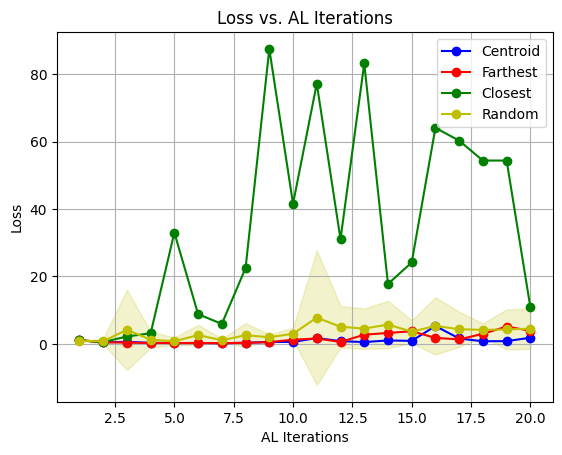

In [31]:
epochs_list = [i+1 for i in range(epochs)]
plt.plot(epochs_list, loss_list[0], marker='o', linestyle='-', color='b', label='Centroid')
plt.plot(epochs_list, loss_list[1], marker='o', linestyle='-', color='r', label = 'Farthest')
plt.plot(epochs_list, loss_list[2], marker='o', linestyle='-', color='g', label='Closest')
random_loss_mean = np.mean(random_losses, axis=0)# + 2*np.std(random_losses, axis=0)
plt.plot(epochs_list, random_loss_mean, marker='o', linestyle='-', color='y', label='Random')
plt.fill_between(epochs_list, random_loss_mean - 2*np.std(random_losses, axis=0), random_loss_mean + 2*np.std(random_losses, axis=0), alpha=0.2, color='y')
plt.title('Loss vs. AL Iterations')
plt.xlabel('AL Iterations') 
plt.ylabel('Loss')
plt.legend() 
plt.grid(True)
plt.show()  

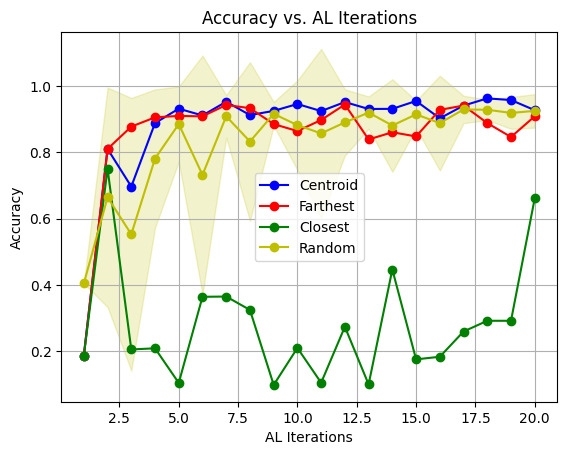

In [32]:
epochs_list = [i+1 for i in range(epochs)]
plt.plot(epochs_list, accuracy_list[0], marker='o', linestyle='-', color='b', label='Centroid')
plt.plot(epochs_list, accuracy_list[1], marker='o', linestyle='-', color='r', label = 'Farthest')
plt.plot(epochs_list, accuracy_list[2], marker='o', linestyle='-', color='g', label='Closest')
random_loss_mean = np.mean(random_accuracy, axis=0)# + 2*np.std(random_accuracy, axis=0)
plt.plot(epochs_list, random_loss_mean, marker='o', linestyle='-', color='y', label='Random')
plt.fill_between(epochs_list, random_loss_mean - 2*np.std(random_accuracy, axis=0), random_loss_mean + 2*np.std(random_accuracy, axis=0), alpha=0.2, color='y')
plt.title('Accuracy vs. AL Iterations')
plt.xlabel('AL Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()  

Observation and findings:
- Loss vs AL iteration: we see from the start of the training the loss is less and is not further decreasing. This is maybe because the task is simple and the model is able to learn the task in the first few epochs itself. 
- Accuracy vs AL iteration: we see that the accuracy is increasing with increasing in the train dataset size. This is because the model is able generalize better with more data.
- For Closest acquisition function function model is not able to learn the task well. This is because the selected points are not diverse enough for the model to learn better.
- Farthest acquisition function is comparable to random sampling.
- Centroid acquisition function is better than closest but not as good as farthest and random sampling. 

So based on the above observations we can say that farthest acquisition function is comparable to random sampling and better than centroid and closest acquisition function.